# <span style="color: darkblue;">**Exploratory Data Analysis**</span>

This project aims to analyze transactional data from an online UK-based retail store, covering customer purchases made between December 2010 and December 2011. Our primary goal is to explore sales trends, product performance, and customer demographics to gain deeper insights into purchasing behavior.  

### **Key Steps in This Analysis:**  

1. **[Data Preprocessing](#section1)**: *Loading transactional data into an SQLite database for efficient querying and analysis.*  
2. **[Exploratory Data Analysis (EDA)](#section2)**: *Analyzing sales trends, product performance, and customer demographics to insights into customer purchasing behavior.*
3. **[Insights & Recommendations](#section3)**: *Deriving actionable strategies from segment performance to optimize retention, reactivation, and revenue growth.*

<a id="section1"></a>
## <span style="color: #0D47A1;">**Data Preprocessing**</span>

---

In [1]:
# Library for importing database
import pandas as pd
import sqlite3

# Library for visualisation
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.io as pio
from IPython.display import Image, display

In [2]:
# Load the cleaned dataset
df = pd.read_csv("online_retail_cleaned.csv")  

# Connect to SQLite database
conn = sqlite3.connect("online_retail.db")

# Load DataFrame to SQL (automatically creates the table)
df.to_sql("online_retail", conn, if_exists="replace", index=False, dtype={
    "invoice_no": "TEXT",
    "stock_code": "TEXT",
    "description": "TEXT",
    "quantity": "INTEGER",
    "invoice_date": "TEXT",
    "invoice_time": "TEXT",
    "unit_price": "DECIMAL(10,2)",
    "customer_id": "TEXT",
    "country": "TEXT",
    "total_sales": "DECIMAL(10,2)"
})

391153

In [3]:
# Load SQL extension for Jupyter Notebook
%load_ext sql

# Connect to the SQLite database
%sql sqlite:///online_retail.db

# Removing the display limit
%config SqlMagic.displaylimit = 0

Connecting to 'sqlite:///online_retail.db'

In [4]:
%%sql
PRAGMA table_info(online_retail);

Running query in 'sqlite:///online_retail.db'

cid,name,type,notnull,dflt_value,pk
0,invoice_no,TEXT,0,None,0
1,stock_code,TEXT,0,None,0
2,description,TEXT,0,None,0
3,quantity,INTEGER,0,None,0
4,invoice_date,TEXT,0,None,0
5,unit_price,"DECIMAL(10,2)",0,None,0
6,customer_id,TEXT,0,None,0
7,country,TEXT,0,None,0
8,invoice_time,TEXT,0,None,0
9,total_sales,"DECIMAL(10,2)",0,None,0


In [5]:
%%sql
SELECT * FROM online_retail LIMIT 5;

Running query in 'sqlite:///online_retail.db'

invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,invoice_time,total_sales
536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850,United Kingdom,08:26:00,15.3
536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850,United Kingdom,08:26:00,20.34
536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850,United Kingdom,08:26:00,22
536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850,United Kingdom,08:26:00,20.34
536365,84029E,RED WOOLLY HOTTIE WHITE HEART,6,2010-12-01,3.39,17850,United Kingdom,08:26:00,20.34


<a id="section2"></a>
## <span style="color: #0D47A1;">**Exploratory Data Analysis (EDA)**</span>

---

### **1. Key Performance Indicators (KPIs):**
- *Total Number of Transactions* 
- *Total Revenue Generated*
- *Number of Unique Customers* 
- *Average Order Value (AOV)*

In [6]:
%%sql
SELECT 
    COUNT(DISTINCT invoice_no) AS total_transactions,
    ROUND(SUM(total_sales), 2) AS total_revenue,
    COUNT(DISTINCT customer_id) AS unique_customers,
    ROUND(SUM(total_sales) / COUNT(DISTINCT invoice_no), 2) AS avg_order_value
FROM online_retail;

Running query in 'sqlite:///online_retail.db'

total_transactions,total_revenue,unique_customers,avg_order_value
18402,8737227.64,4334,474.8


> The dataset contains **18,402 unique transactions**, generating a **total revenue of £8.74 million**. There are **4,334 unique customers**, and the **average order value (AOV)** is approximately **£474.80**, indicating a relatively high spend per transaction on average.

### 2. **Revenue Trends Over Time**
*How much revenue was gained or lost month-over-month?*

In [7]:
query = """
WITH monthly_revenue AS (
    SELECT strftime('%Y-%m', invoice_date) AS month, 
           ROUND(SUM(total_sales), 2) AS monthly_revenue
    FROM online_retail
    GROUP BY month
    ORDER BY month
)
SELECT 
    month, 
    monthly_revenue,
    ROUND(((monthly_revenue - LAG(monthly_revenue) OVER (ORDER BY month)) / 
          LAG(monthly_revenue) OVER (ORDER BY month)) * 100, 2) AS growth_rate,
    CASE 
        WHEN (monthly_revenue - LAG(monthly_revenue) OVER (ORDER BY month)) >= 0 
        THEN '+' || ROUND((monthly_revenue - LAG(monthly_revenue) OVER (ORDER BY month)), 2)
        ELSE ROUND((monthly_revenue - LAG(monthly_revenue) OVER (ORDER BY month)), 2)
    END AS revenue_change
FROM monthly_revenue;
"""

df_revenue = pd.read_sql(query, conn)
df_revenue

,month,monthly_revenue,growth_rate,revenue_change
0,2010-12,565199.56,NaN,None
1,2011-01,562682.91,-0.45,-2516.65
2,2011-02,442293.59,-21.40,-120389.32
3,2011-03,583143.85,31.85,+140850.26
4,2011-04,454440.88,-22.07,-128702.97
5,2011-05,659242.49,45.07,+204801.61
6,2011-06,653264.92,-0.91,-5977.57
7,2011-07,591603.79,-9.44,-61661.13
8,2011-08,635514.38,7.42,+43910.59
9,2011-09,938752.63,47.72,+303238.25


#### **2.1 Monthly Revenue Trend**

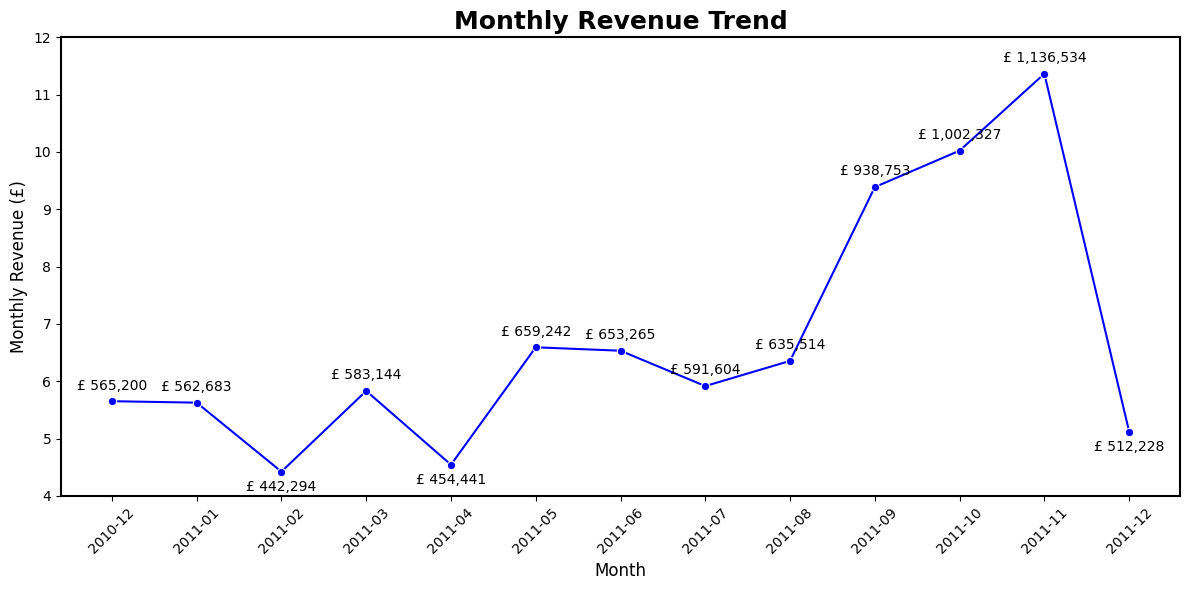

In [8]:
# Scale the total revenue by 100,000 for the y-axis
df_revenue['scaled_revenue'] = df_revenue['monthly_revenue'] / 100000

# Plotting the line chart
plt.figure(figsize=(12, 6))
ax = sns.lineplot(x="month", y="scaled_revenue", data=df_revenue, marker="o", color="b")
ax.grid(False)
ax.set_ylim(4, 12)  # Set y-axis limit to 12

for spine in ax.spines.values():  
    spine.set_color('black')
    spine.set_linewidth(1.5)

for x, y, full_value in zip(df_revenue['month'], df_revenue['scaled_revenue'], df_revenue['monthly_revenue']):
    label = f'£ {full_value:,.0f}'
    if y < 5.5: 
        ax.text(x, y - 0.15, label, ha='center', va='top', fontsize=10)
    else:      
        ax.text(x, y + 0.15, label, ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=45)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Monthly Revenue (£)", fontsize=12)
plt.title("Monthly Revenue Trend", fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

> The overall revenue trend fluctuates across the year, with noticeable peaks in **March, May, September, October, and November 2011**. The highest revenue was recorded in **November 2011**, indicating a seasonal boost likely due to holiday shopping.

#### **2.2 Month-over-Month Revenue Change**

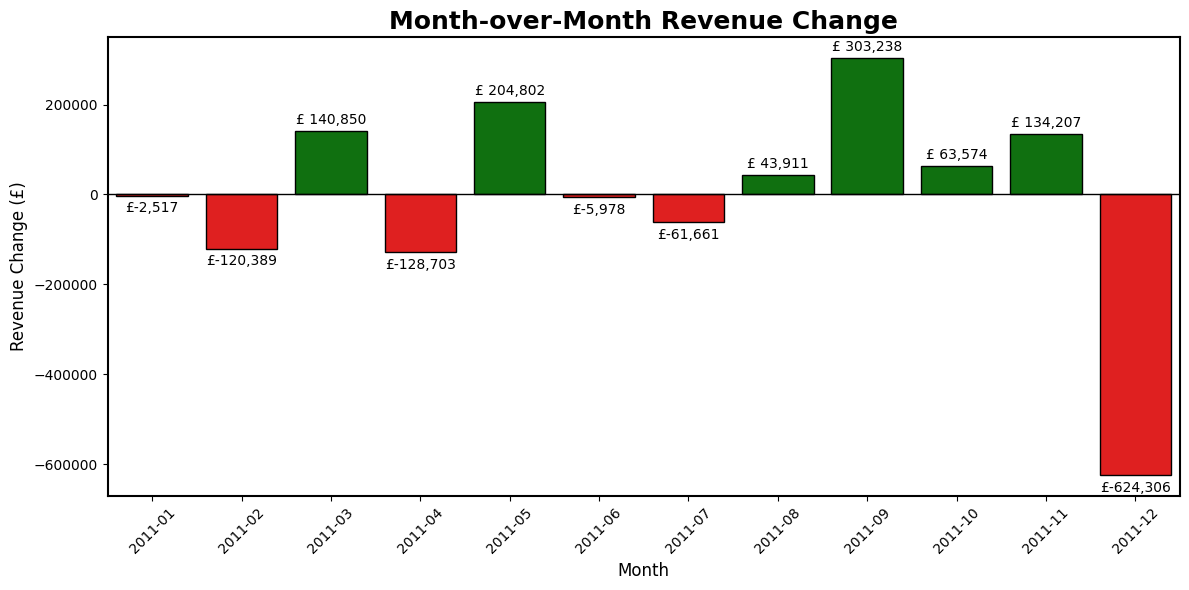

In [9]:
# Convert to numeric and remove first month
df_revenue['revenue_change'] = pd.to_numeric(df_revenue['revenue_change'], errors='coerce')
df_revenue['change_type'] = np.where(df_revenue['revenue_change'] >= 0, 'positive', 'negative')
df_revenue_filtered = df_revenue.dropna(subset=['revenue_change']).copy()

# Plotting the figure
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='month', y='revenue_change', hue='change_type', data=df_revenue_filtered, palette={'positive': 'green', 'negative': 'red'}, 
                 dodge=False, edgecolor='black')
ax.get_legend().remove()
plt.axhline(0, color='black', linewidth=1)

# Add value labels above/below the bars 
for pos, row in enumerate(df_revenue_filtered.itertuples()):
    change = row.revenue_change
    if change >= 0:
        ax.text(pos,  change + 0.03 * df_revenue_filtered['revenue_change'].max(), f"£ {change:,.0f}", ha='center', va='bottom', fontsize=10)
    else:
        ax.text(pos, change - 0.02 * abs(df_revenue_filtered['revenue_change'].min()), f"£{change:,.0f}", ha='center', va='top', fontsize=10)

ax.grid(False)
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)

plt.title("Month-over-Month Revenue Change", fontsize=18, fontweight='bold')
plt.xlabel("Month", fontsize=12)
plt.ylabel("Revenue Change (£)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

> There were **sharp increases** in revenue during **March, May, September, and November**, while significant **declines** occurred in **February, April, and December**. The **largest drop** was observed in **December 2011**, potentially due to post-holiday slowdown.

#### **2.3 Month-over-Month Growth Rate**

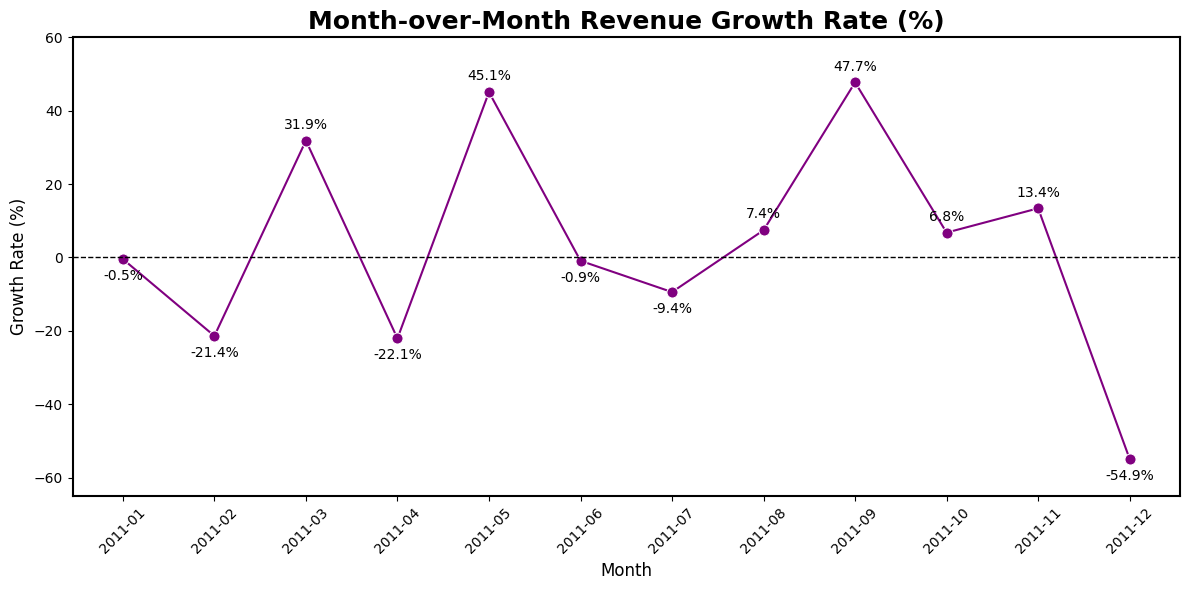

In [10]:
# Convert growth_rate to numeric & drop NaN (first month)
df_revenue['growth_rate'] = pd.to_numeric(df_revenue['growth_rate'], errors='coerce')
df_revenue_filtered = df_revenue.dropna(subset=['growth_rate']).copy()

# Plotting the figure
plt.figure(figsize=(12, 6))
ax = sns.lineplot(x='month', y='growth_rate', data=df_revenue_filtered,   marker='o', markersize=8, color='purple')

for x, y in zip(df_revenue_filtered['month'], df_revenue_filtered['growth_rate']):
    label = f'{y:.1f}%'
    if y >= 0:
        offset = 0.05 * df_revenue_filtered['growth_rate'].max()  # Positive values - label above
        va = 'bottom'
    else:
        offset = 0.05 * abs(df_revenue_filtered['growth_rate'].min())  # Negative values - label below
        va = 'top'
    ax.text(x, y + offset if y >= 0 else y - offset, label, ha='center', va=va, fontsize=10)

ax.axhline(0, color='black', linewidth=1, linestyle='--')   # Draw zero line
ax.grid(False)
ax.set_ylim(-65, 60)
for spine in ax.spines.values():
    spine.set_color('black')
    spine.set_linewidth(1.5)

plt.title("Month-over-Month Revenue Growth Rate (%)", fontsize=18, fontweight='bold')
plt.xlabel("Month", fontsize=12)
plt.ylabel("Growth Rate (%)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

> Revenue growth was highly **volatile** throughout the year. The **strongest positive growth** occurred in **May (45.07%)** and **September (47.72%)**, whereas **December saw the steepest decline**, with a growth rate of **-54.93%**.

### **3. Sales Activity by Time and Day**
*What times of day and days of the week drive the most sales?*

#### **3.1 Total Purchases and Revenue by Hour of the Day**

In [11]:
query = """
SELECT 
    strftime('%H', invoice_time) AS purchase_hour,  
    COUNT(DISTINCT invoice_no) AS total_purchases,
    ROUND(100.0 * COUNT(DISTINCT invoice_no) / SUM(COUNT(DISTINCT invoice_no)) OVER (), 1) AS purchase_percentage,
    ROUND(SUM(total_sales), 2) AS total_revenue,
    ROUND(100.0 * SUM(total_sales) / SUM(SUM(total_sales)) OVER (), 1) AS revenue_percentage
FROM online_retail
WHERE invoice_time IS NOT NULL
GROUP BY purchase_hour
ORDER BY purchase_hour;
"""

df_purchase_day = pd.read_sql(query, conn)
df_purchase_day

,purchase_hour,total_purchases,purchase_percentage,total_revenue,revenue_percentage
0,06,1,0.0,4.25,0.0
1,07,29,0.2,30469.21,0.3
2,08,554,3.0,277544.79,3.2
3,09,1383,7.5,829081.54,9.5
4,10,2204,12.0,1242520.50,14.2
5,11,2262,12.3,1083973.01,12.4
6,12,3118,16.9,1361080.82,15.6
7,13,2623,14.3,1138402.80,13.0
8,14,2251,12.2,967716.43,11.1
9,15,2021,11.0,947369.57,10.8


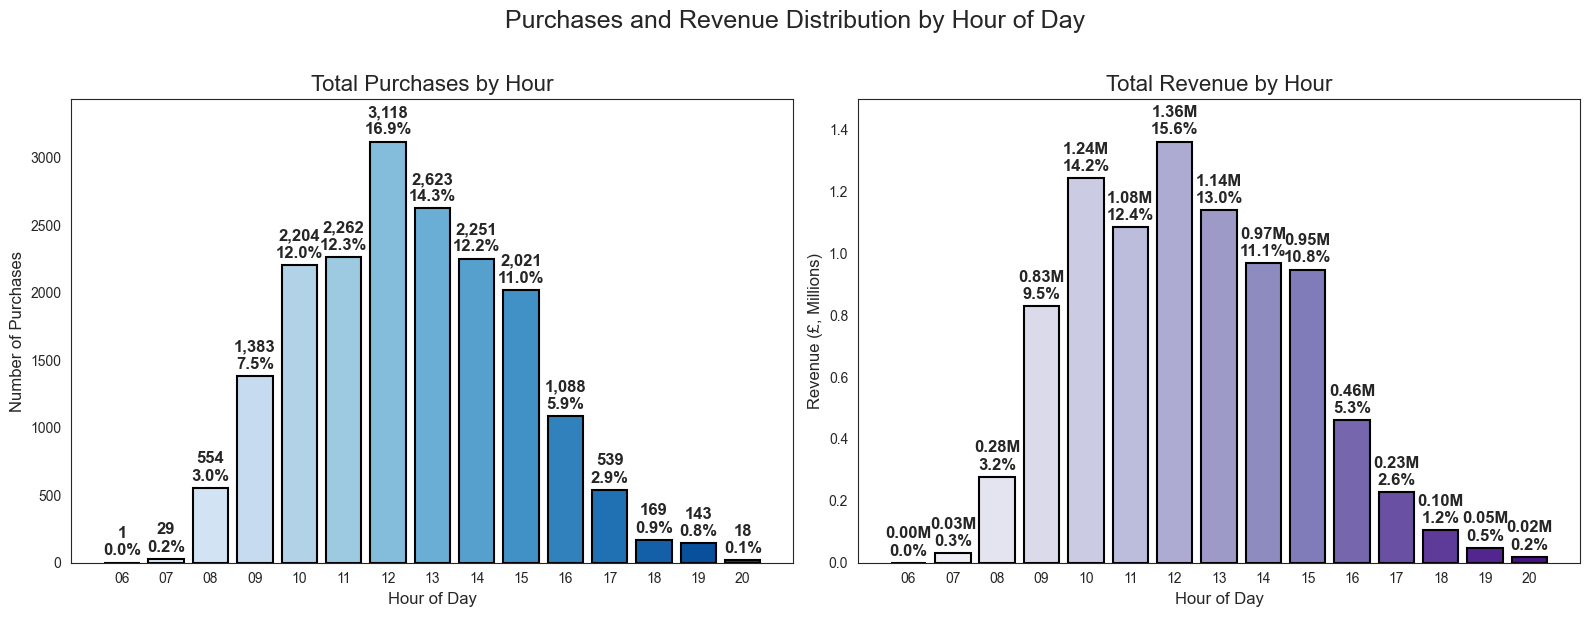

In [12]:
# Prepare the data
df = df_purchase_day.sort_values('purchase_hour')
purchase_hours = df['purchase_hour']
purchases = df['total_purchases']
revenues = df['total_revenue'] / 1_000_000  # Convert to millions
purchase_pct = df['purchase_percentage']
revenue_pct = df['revenue_percentage']

# Plotting the figure
sns.set_style("white")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
bar_border = {'edgecolor': 'black', 'linewidth': 1.5}
purchase_colors = sns.color_palette("Blues", n_colors=len(purchase_hours))
revenue_colors = sns.color_palette("Purples", n_colors=len(purchase_hours))

# --- Plot 1: Purchases ---
bars1 = axes[0].bar(purchase_hours, purchases, color=purchase_colors, **bar_border)
axes[0].set_title("Total Purchases by Hour", fontsize=16)
axes[0].set_xlabel("Hour of Day", fontsize=12)
axes[0].set_ylabel("Number of Purchases", fontsize=12)
axes[0].grid(False)

for i, bar in enumerate(bars1):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2, height + max(purchases)*0.01, f"{purchases[i]:,}\n{purchase_pct[i]:.1f}%", 
                 ha='center', va='bottom', fontsize=12, fontweight='semibold')
max_purchase = max(purchases)
axes[0].set_ylim(0, max_purchase * 1.10)

# --- Plot 2: Revenue ---
bars2 = axes[1].bar(purchase_hours, revenues, color=revenue_colors, **bar_border)
axes[1].set_title("Total Revenue by Hour", fontsize=16)
axes[1].set_xlabel("Hour of Day", fontsize=12)
axes[1].set_ylabel("Revenue (£, Millions)", fontsize=12)
axes[1].grid(False)

for i, bar in enumerate(bars2):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2, height + max(revenues)*0.01, f"{revenues[i]:.2f}M\n{revenue_pct[i]:.1f}%",
                 ha='center', va='bottom', fontsize=12, fontweight='semibold')
max_revenue = max(revenues)
axes[1].set_ylim(0, max_revenue * 1.10)

# Final layout
plt.suptitle("Purchases and Revenue Distribution by Hour of Day", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

> Sales activity peaks between **10 AM and 3 PM**, marking the busiest purchasing window of the day. This period contributes to around **79% of all transactions** and **77% of revenue**. Within this timeframe, the **peak hour is 12 PM**, generating the highest number of orders and revenue.

#### **3.2 Total Purchases and Revenue by Day of the Week**

In [13]:
query = """
SELECT 
    CASE 
        WHEN CAST(STRFTIME('%w', invoice_date) AS INTEGER) = 0 THEN 'Sunday'
        WHEN CAST(STRFTIME('%w', invoice_date) AS INTEGER) = 1 THEN 'Monday'
        WHEN CAST(STRFTIME('%w', invoice_date) AS INTEGER) = 2 THEN 'Tuesday'
        WHEN CAST(STRFTIME('%w', invoice_date) AS INTEGER) = 3 THEN 'Wednesday'
        WHEN CAST(STRFTIME('%w', invoice_date) AS INTEGER) = 4 THEN 'Thursday'
        WHEN CAST(STRFTIME('%w', invoice_date) AS INTEGER) = 5 THEN 'Friday'
        WHEN CAST(STRFTIME('%w', invoice_date) AS INTEGER) = 6 THEN 'Saturday'
    END AS purchase_day,
    COUNT(DISTINCT invoice_no) AS total_purchases,
    ROUND(100.0 * COUNT(DISTINCT invoice_no) / SUM(COUNT(DISTINCT invoice_no)) OVER (), 2) AS purchase_percentage,
    ROUND(SUM(total_sales), 2) AS total_revenue,
    ROUND(100.0 * SUM(total_sales) / SUM(SUM(total_sales)) OVER (), 2) AS revenue_percentage
FROM online_retail
GROUP BY purchase_day;
"""
df_purchase_week = pd.read_sql(query, conn)
df_purchase_week

,purchase_day,total_purchases,purchase_percentage,total_revenue,revenue_percentage
0,Friday,2809,15.26,1459797.08,16.71
1,Monday,2830,15.38,1326500.48,15.18
2,Sunday,2168,11.78,779738.80,8.92
3,Thursday,4003,21.75,1939228.91,22.20
4,Tuesday,3156,17.15,1672493.12,19.14
5,Wednesday,3436,18.67,1559469.25,17.85


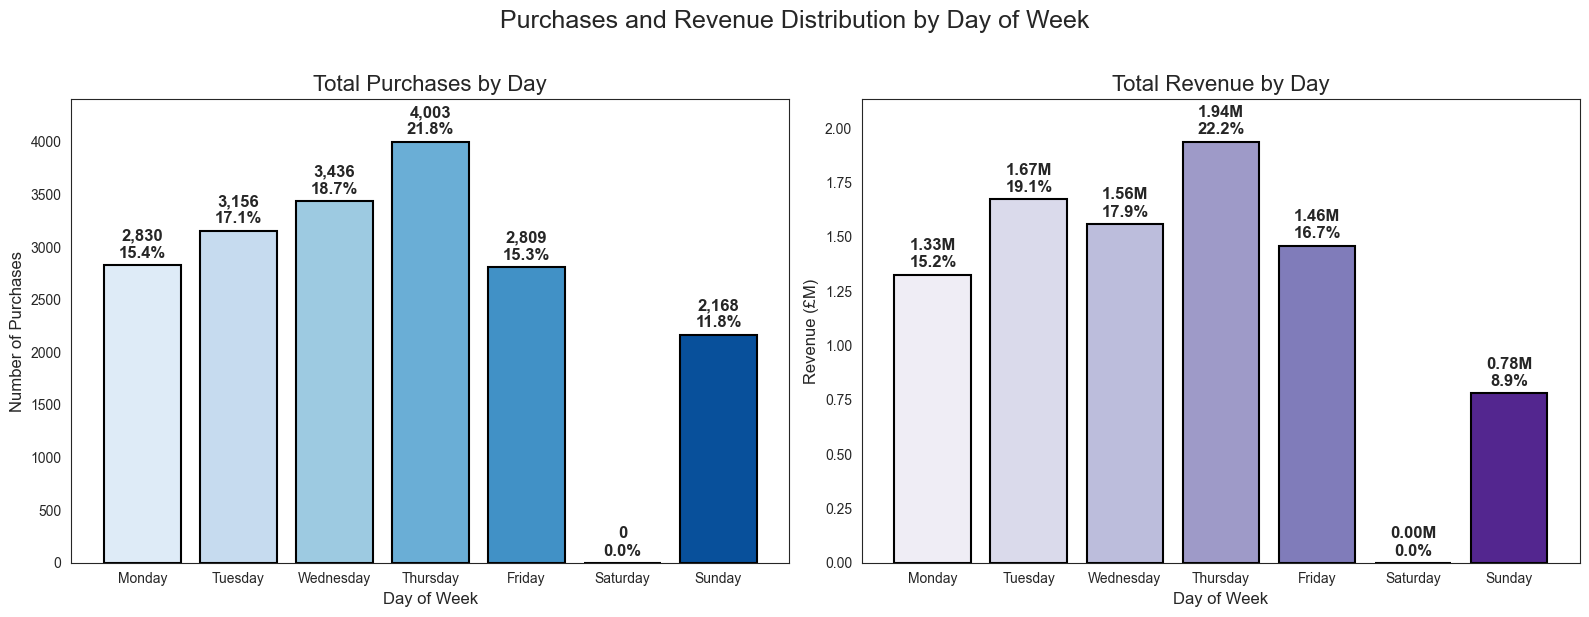

In [14]:
# Prepare the data
df = df_purchase_week.copy()
df = df.set_index('purchase_day').reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).reset_index()

# Fill missing values with 0
df[['total_purchases', 'purchase_percentage', 'total_revenue', 'revenue_percentage']] = \
    df[['total_purchases', 'purchase_percentage', 'total_revenue', 'revenue_percentage']].fillna(0)     # Fill missing values with 0

# Convert to proper types to plot 
purchase_days = df['purchase_day']
purchases = df['total_purchases'].astype(int)
revenues = df['total_revenue'] / 1_000_000  # Revenue in £M
purchase_pct = df['purchase_percentage']
revenue_pct = df['revenue_percentage']

# Plotting the figure
sns.set_style("white")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
bar_border = {'edgecolor': 'black', 'linewidth': 1.5}
purchase_colors = sns.color_palette("Blues", n_colors=len(purchase_days))
revenue_colors = sns.color_palette("Purples", n_colors=len(purchase_days))

# --- Plot 1: Purchases ---
bars1 = axes[0].bar(purchase_days, purchases, color=purchase_colors, **bar_border)
axes[0].set_title("Total Purchases by Day", fontsize=16)
axes[0].set_xlabel("Day of Week", fontsize=12)
axes[0].set_ylabel("Number of Purchases", fontsize=12)
axes[0].grid(False)

for i, bar in enumerate(bars1):
    height = bar.get_height()
    axes[0].text(
        bar.get_x() + bar.get_width() / 2, height + max(purchases)*0.01,
        f"{purchases[i]:,}\n{purchase_pct[i]:.1f}%",
        ha='center', va='bottom', fontsize=12, fontweight='semibold')
axes[0].set_ylim(0, max(purchases)*1.10)

# --- Plot 2: Revenue ---
bars2 = axes[1].bar(purchase_days, revenues, color=revenue_colors, **bar_border)
axes[1].set_title("Total Revenue by Day", fontsize=16)
axes[1].set_xlabel("Day of Week", fontsize=12)
axes[1].set_ylabel("Revenue (£M)", fontsize=12)
axes[1].grid(False)

for i, bar in enumerate(bars2):
    height = bar.get_height()
    axes[1].text(
        bar.get_x() + bar.get_width() / 2, height + max(revenues)*0.01,
        f"{revenues[i]:.2f}M\n{revenue_pct[i]:.1f}%",
        ha='center', va='bottom', fontsize=12, fontweight='semibold')
axes[1].set_ylim(0, max(revenues)*1.10)

# Final layout
plt.suptitle("Purchases and Revenue Distribution by Day of Week", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

> When examining weekly patterns, **Monday to Friday** accounts for the majority of activity during these core hours, contributing **88% of total transactions** and **91% of revenue**. **Thursday** records the highest sales volume and revenue, followed by Wednesday and Tuesday.

#### **3.3 Purchases and Revenue by Day and Hour (Heatmap)**

In [15]:
query = """
SELECT 
    CASE 
        WHEN CAST(STRFTIME('%w', invoice_date) AS INTEGER) = 0 THEN 'Sunday'
        WHEN CAST(STRFTIME('%w', invoice_date) AS INTEGER) = 1 THEN 'Monday'
        WHEN CAST(STRFTIME('%w', invoice_date) AS INTEGER) = 2 THEN 'Tuesday'
        WHEN CAST(STRFTIME('%w', invoice_date) AS INTEGER) = 3 THEN 'Wednesday'
        WHEN CAST(STRFTIME('%w', invoice_date) AS INTEGER) = 4 THEN 'Thursday'
        WHEN CAST(STRFTIME('%w', invoice_date) AS INTEGER) = 5 THEN 'Friday'
        WHEN CAST(STRFTIME('%w', invoice_date) AS INTEGER) = 6 THEN 'Saturday'
    END AS purchase_day, 
    strftime('%H', invoice_time) AS purchase_hour, 
    COUNT(DISTINCT invoice_no) AS total_orders, 
    ROUND(SUM(total_sales), 2) AS total_revenue
FROM online_retail 
GROUP BY purchase_day, purchase_hour 
ORDER BY purchase_day, purchase_hour;
"""
df_sales = pd.read_sql(query, conn)
df_sales

,purchase_day,purchase_hour,total_orders,total_revenue
0,Friday,07,6,16834.88
1,Friday,08,120,51492.61
2,Friday,09,265,294123.83
3,Friday,10,405,176603.76
4,Friday,11,363,164516.75
...,...,...,...,...
68,Wednesday,15,369,158389.10
69,Wednesday,16,222,80717.46
70,Wednesday,17,79,23152.06
71,Wednesday,19,2,2893.40


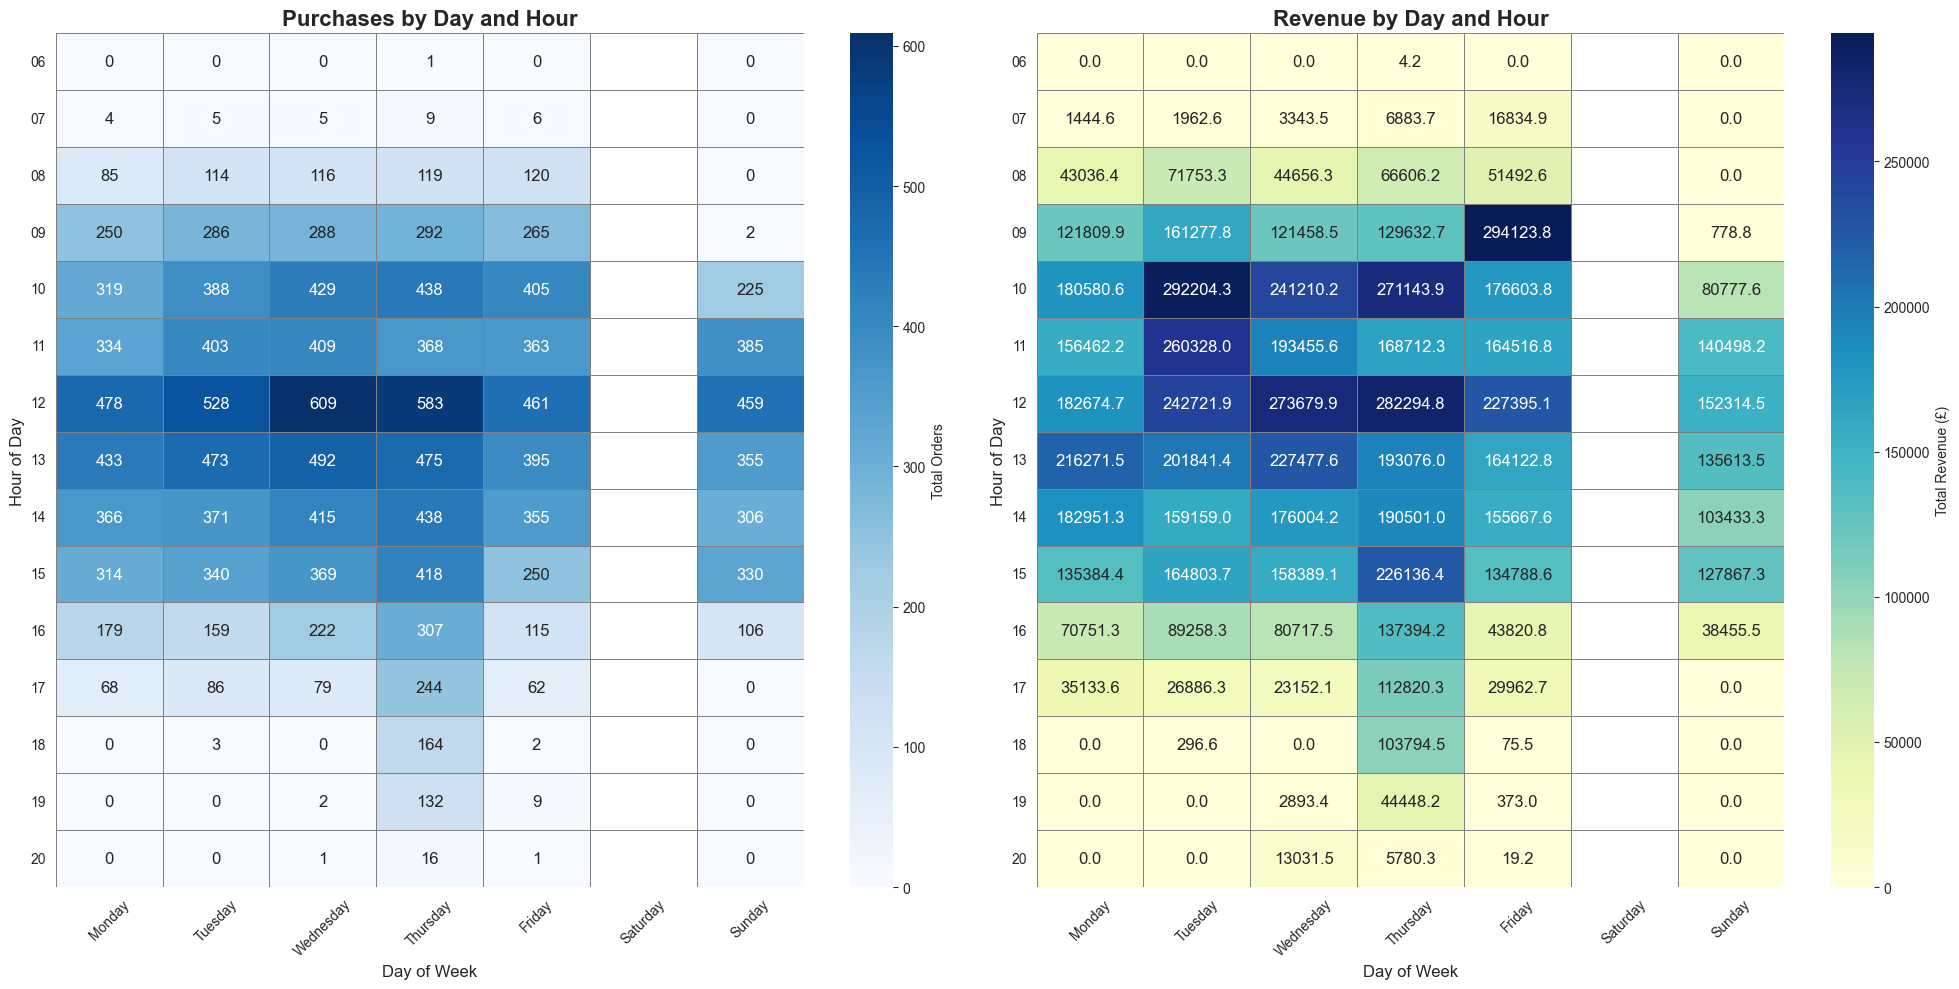

In [16]:
# Define correct day order for heatmap columns
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create pivot table for purchases
heatmap_purchases = df_sales.pivot_table(index='purchase_hour', columns='purchase_day', values='total_orders', fill_value=0)
heatmap_purchases = heatmap_purchases.reindex(columns=day_order)
heatmap_revenue = df_sales.pivot_table(index='purchase_hour', columns='purchase_day', values='total_revenue', fill_value=0)
heatmap_revenue = heatmap_revenue.reindex(columns=day_order)

# Plotting the figure
plt.figure(figsize=(20, 10))

# --- Heatmap 1: Purchases ---
ax1 = plt.subplot(1, 2, 1)
sns.heatmap(heatmap_purchases, cmap='Blues', linewidths=0.5, linecolor='gray', annot=True, fmt='g', cbar_kws={'label': 'Total Orders'}, 
            annot_kws={"size": 12}, ax=ax1)
ax1.set_title('Purchases by Day and Hour', fontsize=16, fontweight='bold')
ax1.set_xlabel('Day of Week', fontsize=12)
ax1.set_ylabel('Hour of Day', fontsize=12)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)

# --- Heatmap 2: Revenue ---
ax2 = plt.subplot(1, 2, 2)
sns.heatmap(heatmap_revenue, cmap='YlGnBu', linewidths=0.5, linecolor='gray', annot=True, fmt='.1f', cbar_kws={'label': 'Total Revenue (£)'},
            annot_kws={"size": 12}, ax=ax2)
ax2.set_title('Revenue by Day and Hour', fontsize=16, fontweight='bold')
ax2.set_xlabel('Day of Week', fontsize=12)
ax2.set_ylabel('Hour of Day', fontsize=12)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()

> Heatmaps confirm that **midday period (10 AM to 3 PM)** from **Monday to Friday** dominates revenue and orders. This reveals a clear midday, midweek shopping trend, presenting a prime opportunity to launch time-sensitive deals, targeted email campaigns, or flash sales to maximize conversions during peak buying behavior.

### **4. Product Performance Analysis**
*Which products are top performers in revenue and quantity?*

In [17]:
%%sql
SELECT 
    DENSE_RANK() OVER (ORDER BY SUM(total_sales) DESC) AS rank,
    stock_code, 
    description, 
    SUM(quantity) AS total_quantity_sold,
    ROUND(SUM(total_sales), 1) AS total_revenue
FROM online_retail
GROUP BY description
ORDER BY total_revenue DESC, total_quantity_sold DESC
LIMIT 10;

Running query in 'sqlite:///online_retail.db'

rank,stock_code,description,total_quantity_sold,total_revenue
1,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,168469.6
2,22423,REGENCY CAKESTAND 3 TIER,12374,142264.7
3,85123A,WHITE HANGING HEART T-LIGHT HOLDER,36706,100392.1
4,85099B,JUMBO BAG RED RETROSPOT,46078,85040.5
5,23166,MEDIUM CERAMIC TOP STORAGE JAR,77916,81416.7
6,47566,PARTY BUNTING,15279,68785.2
7,84879,ASSORTED COLOUR BIRD ORNAMENT,35263,56413.0
8,23084,RABBIT NIGHT LIGHT,27153,51251.2
9,79321,CHILLI LIGHTS,9646,46265.1
10,22086,PAPER CHAIN KIT 50'S CHRISTMAS,15591,42584.1


#### **4.1 Top 10 Products: Revenue vs. Sales Volume**

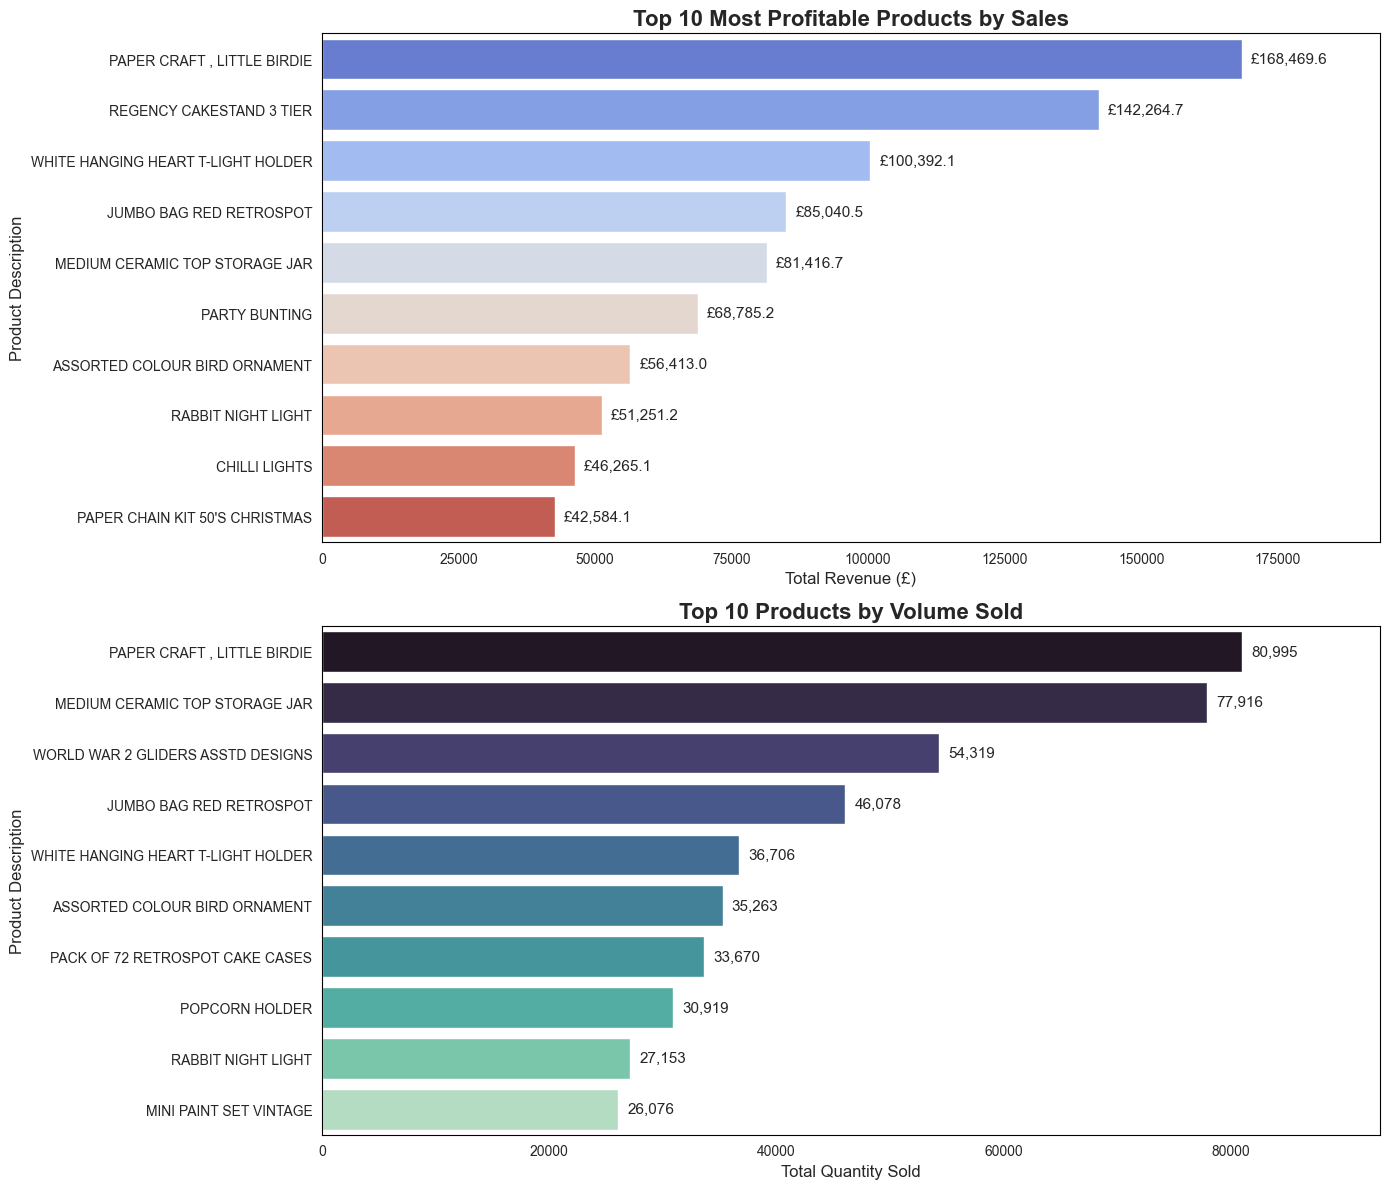

In [18]:
# Run the combined query
query_combined = """
    SELECT 
        stock_code, 
        description, 
        SUM(quantity) AS total_quantity_sold,
        ROUND(SUM(total_sales), 1) AS total_revenue
    FROM online_retail
    GROUP BY description
"""
df_products = pd.read_sql(query_combined, conn)

# Top 10 by Total Revenue & Quantity Sold
df_top_revenue = df_products.sort_values(by='total_revenue', ascending=False).head(10).reset_index(drop=True)
df_top_volume = df_products.sort_values(by='total_quantity_sold', ascending=False).head(10).reset_index(drop=True)

# Plotting the figure
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 12))

# --- Fig 1: Top 10 Most Profitable Products by Revenue ---
sns.barplot(x="total_revenue", y="description", data=df_top_revenue, hue="description", palette="coolwarm", dodge=False, legend=False, ax=axes[0])
axes[0].grid(False)
for spine in axes[0].spines.values():
    spine.set_color('black')
max_revenue = df_top_revenue['total_revenue'].max()
axes[0].set_xlim(0, max_revenue * 1.15)
for i, value in enumerate(df_top_revenue['total_revenue']):
    axes[0].text(value + (max_revenue * 0.01), i, f'£{value:,.1f}', va='center', fontsize=11, clip_on=True)
axes[0].set_xlabel("Total Revenue (£)", fontsize=12)
axes[0].set_ylabel("Product Description", fontsize=12)
axes[0].set_title("Top 10 Most Profitable Products by Sales", fontsize=16, fontweight='bold')

# --- Fig 2: Top 10 Products by Volume Sold ---
sns.barplot(x="total_quantity_sold", y="description", data=df_top_volume, hue="description", palette="mako", dodge=False, legend=False, ax=axes[1])
axes[1].grid(False)
for spine in axes[1].spines.values():
    spine.set_color('black')
max_volume = df_top_volume['total_quantity_sold'].max()
axes[1].set_xlim(0, max_volume * 1.15)
for i, value in enumerate(df_top_volume['total_quantity_sold']):
    axes[1].text(value + (max_volume * 0.01), i, f'{value:,}', va='center', fontsize=11, clip_on=True)
axes[1].set_xlabel("Total Quantity Sold", fontsize=12)
axes[1].set_ylabel("Product Description", fontsize=12)
axes[1].set_title("Top 10 Products by Volume Sold", fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

> The top-performing product by both revenue and quantity sold is **“PAPER CRAFT , LITTLE BIRDIE”**, generating over **£168K** in revenue with more than **80,000** units sold. Other top items include decorative and gifting products like **“REGENCY CAKESTAND 3 TIER”** and **“WHITE HANGING HEART T-LIGHT HOLDER”**. This contrast emphasizes that both **volume-driven** and **high-ticket** items are crucial for overall sales performance. Also, these products reflect strong customer interest in home decor and unique, giftable items.                        

#### **4.2 Top 3 Products per Country**

In [19]:
%%sql
WITH product_sales AS (
    SELECT 
        country,
        stock_code,
        description,
        SUM(quantity) AS total_quantity_sold,
        DENSE_RANK() OVER (PARTITION BY country ORDER BY SUM(quantity) DESC) AS rank
    FROM online_retail
    WHERE customer_id IS NOT NULL
    GROUP BY country, stock_code, description
)
SELECT rank, country, stock_code, description, total_quantity_sold 
FROM product_sales
WHERE rank <= 3
      AND country != 'Unknown'
ORDER BY country, rank
LIMIT 10;

Running query in 'sqlite:///online_retail.db'

rank,country,stock_code,description,total_quantity_sold
1,Australia,22492,MINI PAINT SET VINTAGE,2952
2,Australia,23084,RABBIT NIGHT LIGHT,1884
3,Australia,21915,RED HARMONICA IN BOX,1704
1,Austria,21918,SET 12 KIDS COLOUR CHALK STICKS,288
2,Austria,22546,MINI JIGSAW PURDEY,240
3,Austria,22582,PACK OF 6 SWEETIE GIFT BOXES,144
3,Austria,22584,PACK OF 6 PANNETONE GIFT BOXES,144
1,Bahrain,23076,ICE CREAM SUNDAE LIP GLOSS,96
2,Bahrain,23077,DOUGHNUT LIP GLOSS,60
3,Bahrain,22693,GROW A FLYTRAP OR SUNFLOWER IN TIN,24


> The most popular products vary significantly by country, reflecting regional preferences. For example:
> - In **Australia**, creative and novelty items like the **MINI PAINT SET VINTAGE** and **RABBIT NIGHT LIGHT** are top choices.
> - In **Austria**, kids' and gift items like **chalk sticks**, **mini jigsaws**, and **gift boxes** dominate.
> - In **Bahrain**, **lip glosses** and **grow kits** are among the bestsellers, suggesting a preference for small, fun, and practical items.

### **5. Customer Profitability by Country**
*Which countries have the most valuable customers?*

In [20]:
query = """
SELECT 
    country AS "Country",
    COUNT(DISTINCT invoice_no) AS "Total Transactions",
    ROUND(100.0 * COUNT(DISTINCT invoice_no) / SUM(COUNT(DISTINCT invoice_no)) OVER (), 2) AS "Txn % of Total",
    COUNT(DISTINCT customer_id) AS "Total Customers",
    ROUND(100.0 * COUNT(DISTINCT customer_id) / SUM(COUNT(DISTINCT customer_id)) OVER (), 2) AS "Customer % of Total",
    SUM(quantity) AS "Total Quantity Sold",
    ROUND(SUM(total_sales), 2) AS "Total Revenue",
    ROUND(100.0 * SUM(total_sales) / SUM(SUM(total_sales)) OVER (), 2) AS "Revenue % of Total",
    ROUND(SUM(total_sales) * 1.0 / COUNT(DISTINCT invoice_no), 2) AS "Average Order Value",
    ROUND(SUM(total_sales) * 1.0 / COUNT(DISTINCT customer_id), 2) AS "Revenue Per Customer",
    ROUND(SUM(quantity) * 1.0 / COUNT(DISTINCT invoice_no), 2) AS "Avg Quantity Per Order"
FROM online_retail
WHERE country != 'Unknown'
GROUP BY country
ORDER BY "Total Revenue" DESC;
"""

df_country = pd.read_sql(query, conn)
df_country.head(10)

,Country,Total Transactions,Txn % of Total,Total Customers,Customer % of Total,Total Quantity Sold,Total Revenue,Revenue % of Total,Average Order Value,Revenue Per Customer,Avg Quantity Per Order
0,United Kingdom,16579,90.13,3916,90.27,4234315,7242855.32,82.92,436.87,1849.55,255.40
1,Netherlands,93,0.51,9,0.21,200258,283889.34,3.25,3052.57,31543.26,2153.31
2,Ireland,256,1.39,3,0.07,140033,257013.12,2.94,1003.96,85671.04,547.00
3,Germany,443,2.41,94,2.17,118032,205381.15,2.35,463.61,2184.91,266.44
4,France,379,2.06,87,2.01,110594,183801.94,2.10,484.97,2112.67,291.80
5,Australia,56,0.30,9,0.21,83890,138103.81,1.58,2466.14,15344.87,1498.04
6,Spain,88,0.48,30,0.69,27724,55706.56,0.64,633.03,1856.89,315.05
7,Switzerland,47,0.26,21,0.48,29980,52441.95,0.60,1115.79,2497.24,637.87
8,Japan,19,0.10,8,0.18,26016,37416.37,0.43,1969.28,4677.05,1369.26
9,Belgium,98,0.53,25,0.58,22962,36927.34,0.42,376.81,1477.09,234.31


> Dominance of UK Market:
> - The **United Kingdom** dominates the dataset with **3,916 customers** (**90% of all customers**), generating **£7.24 million** in revenue—**82% of total revenue and **90% of all transactions**. Despite the volume, the **average order value** (£437) and **revenue per customer** (£1,850) are **modest** compared to some international markets. This confirms that the business is **heavily concentrated in the domestic market**, making the UK the primary driver of business performance.

> High-Value International Markets:
> - **Netherlands**, **Ireland**, and **Australia** stand out with **xceptional revenue per customer (£15K–£85K)**, suggesting **high-value bulk orders** despite **minimal customer bases**.
> - Countries like **Germany**, **France** and **Spain** show a healthy mix of order volume and value, with revenue per customer ranging between **£1,800 and £2,100**, making them strong mid-tier performers.
> - Netherlands, Ireland, Germany & France collectively contribute 10.6% of revenue (Netherlands alone ranks 2nd in revenue despite 0.5% of transactions).
> - **Japan**, **Switzerland**, **Sweden** and **Lebanon** also have **fewer customers**, but very **high AOVs and revenue per customer**, suggesting **premium purchase behavior**.<br>

> Average order quantities vary dramatically between countries :
> - Netherlands: 2,153 items/order (Highest volume)
> - UK: 255 items/order (Volume-driven)
> - Most countries: 200-600 items/order

> Long Tail of Smaller Markets    
> - 30+ countries each contribute <1% of revenue with low transaction volume. Several of these may represent **growth opportunities** for potential market expansion (e.g., Switzerland with £1,116 AOV) through strategic targeting or localized campaigns.

#### **5.1 Global Sales Distribution by Country**

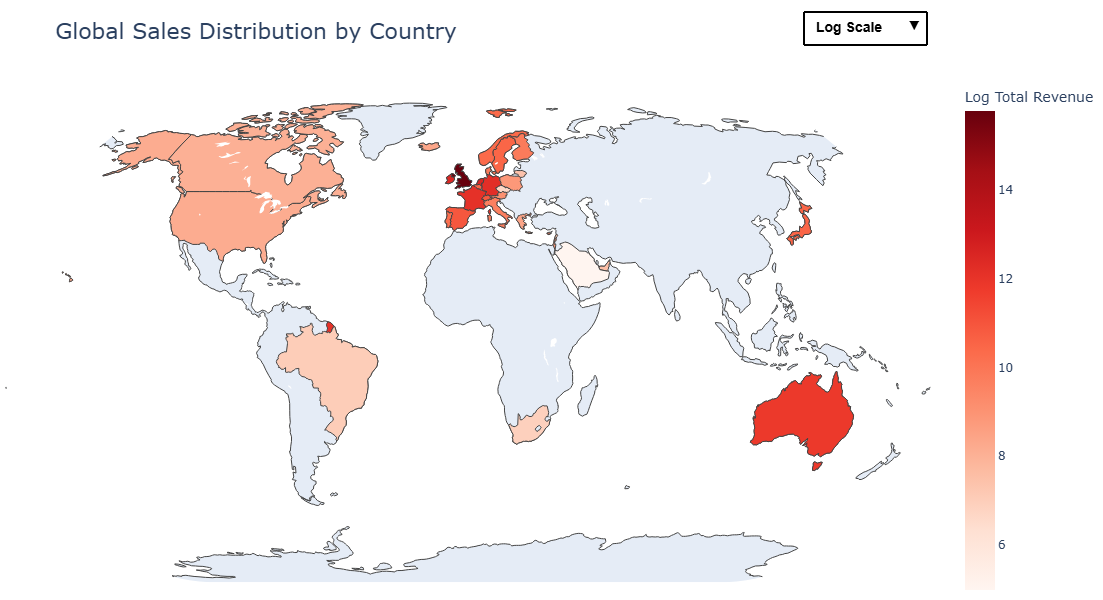

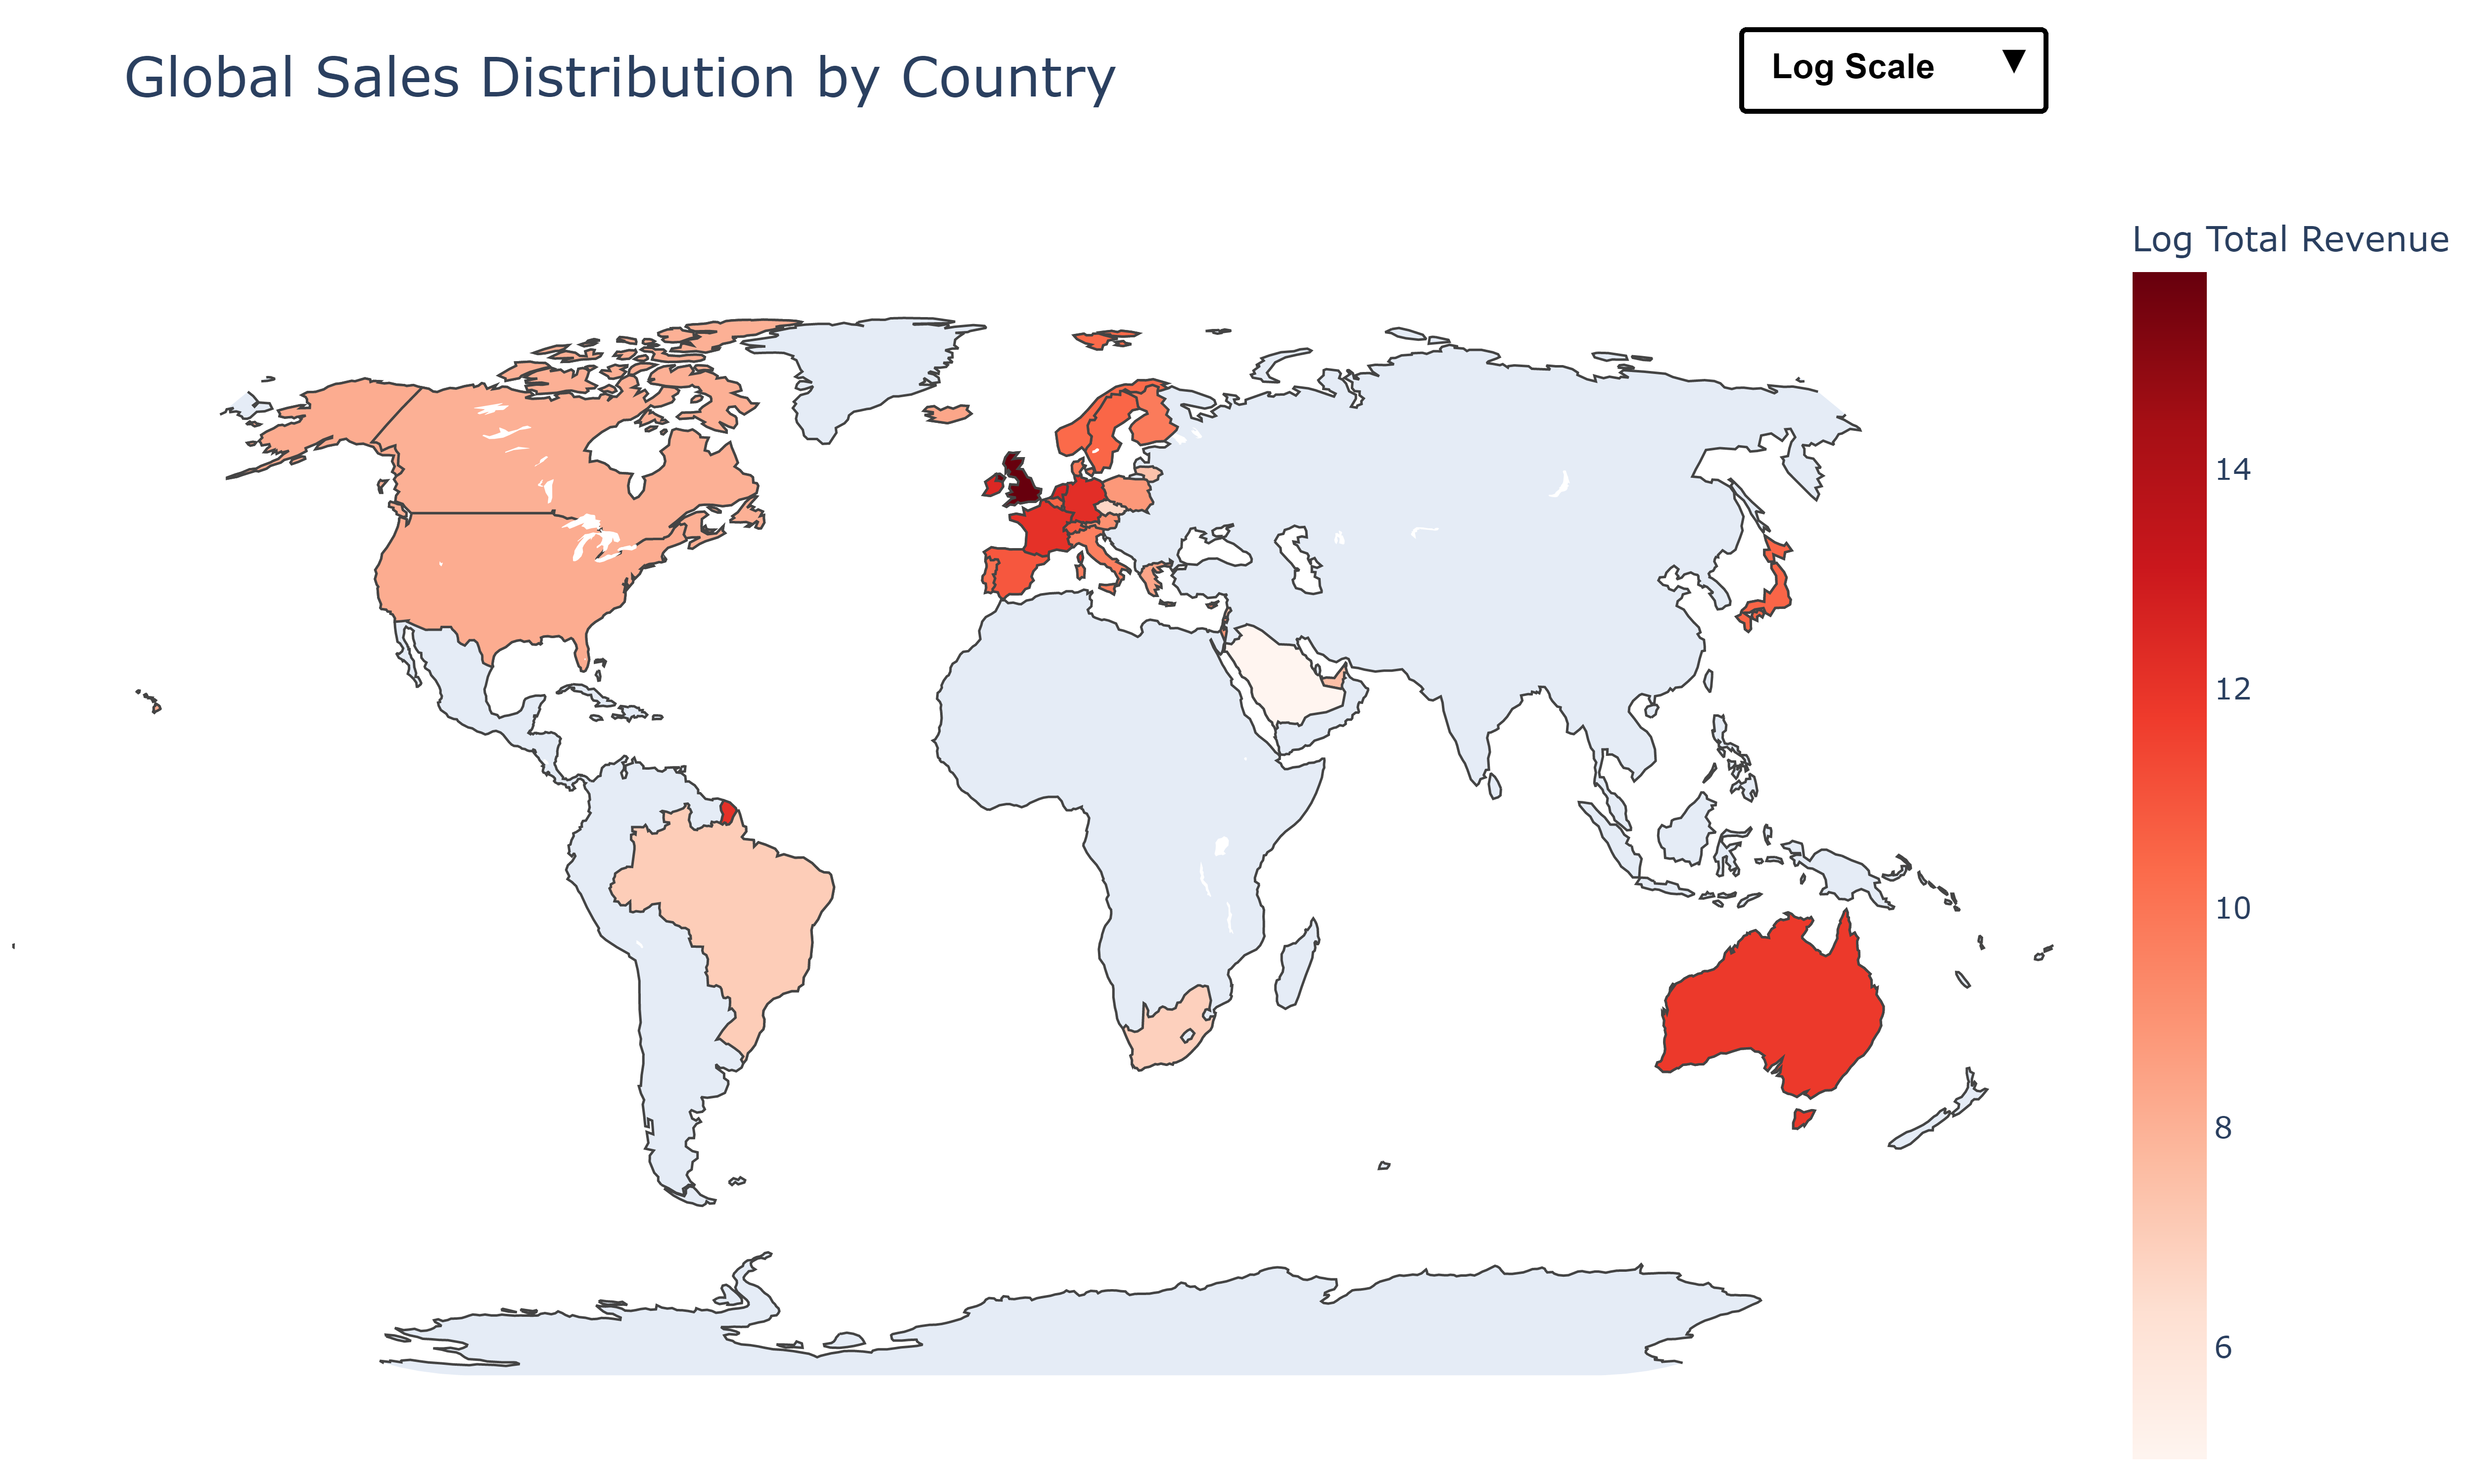

In [22]:
# Creating Log Total Revenue column
df_country['Log Total Revenue'] = np.log(df_country['Total Revenue'])

# Trace 1: Linear Scale Choropleth
linear_trace = go.Choropleth(
    locations=df_country['Country'],
    locationmode='country names',
    z=df_country['Total Revenue'],
    colorscale='Reds',
    colorbar_title='Total Revenue (£)',
    hovertemplate=(
        '<b>%{location}</b><br><br>' +
        'Total Revenue: £%{z:,.2f}<br>' +
        'Total Customers: %{customdata[0]:,}<br>' +
        'Total Quantity Sold: %{customdata[2]:,}<br>' +
        'Average Order Value (AOV): £%{customdata[3]:,.2f}<br>' +
        'Revenue per Customer: £%{customdata[4]:,.2f}<extra></extra>'
    ),
    customdata=df_country[['Total Customers', 'Total Quantity Sold', 'Average Order Value', 'Revenue Per Customer']]
)

# Trace 2: Log Scale Choropleth
log_trace = go.Choropleth(
    locations=df_country['Country'],
    locationmode='country names',
    z=df_country['Log Total Revenue'],
    colorscale='Reds',
    colorbar_title='Log Total Revenue',
    hovertemplate=(
        '<b>%{location}</b><br><br>' +
        'Log Total Revenue: %{z:.2f}<br>' +
        'Total Revenue: £%{customdata[0]:,.2f}<br>' +
        'Total Customers: %{customdata[1]:,}<br>' +
        'Total Quantity Sold: %{customdata[3]:,}<br>' +
        'Average Order Value (AOV): £%{customdata[4]:,.2f}<br>' +
        'Revenue per Customer: £%{customdata[5]:,.2f}<extra></extra>'
    ),
    customdata=df_country[['Total Revenue', 'Total Customers', 'Total Quantity Sold', 'Average Order Value', 'Revenue Per Customer']]
)

# Create figure
fig = go.Figure(data=[linear_trace, log_trace])

# Set initial visibility
fig.data[0].visible = False  # Linear
fig.data[1].visible = True   # Log

# Add dropdown menu
fig.update_layout(
    updatemenus=[
        dict(
            active=1,
            buttons=list([
                dict(label="<b>Linear Scale</b>", method="update",
                     args=[{"visible": [True, False]},
                           {"title": "Global Sales Distribution by Country",
                            "coloraxis_colorbar": {"title": "Total Revenue (£)"}}]),
                dict(label="<b>Log Scale</b>", method="update",
                     args=[{"visible": [False, True]},
                           {"title": "Global Sales Distribution by Country",
                            "coloraxis_colorbar": {"title": "Total Revenue (Log)"}}])
            ]),
            direction="down",
            showactive=True,
            x=1,
            xanchor="right",
            y=1.15,
            yanchor="top",
            bgcolor='white',
            bordercolor='black',
            borderwidth=2,
            font=dict(family="Arial", size=14, color='black'),
            pad={"r": 10, "t": 10, "l": 10, "b": 10}
        )
    ]
)

# Set layout
fig.update_layout(
    title="Global Sales Distribution by Country",
    title_font=dict(size=22),
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='natural earth'
    ),
    width=1100,
    height=600,
    margin=dict(l=0, r=0, t=50, b=0)
)
fig.show()

# Save as standalone HTML
pyo.plot(fig, filename="choropleth_global_revenue.html", auto_open=False)
# Save static image of the figure
pio.write_image(fig, "choropleth_map.png", format="png", width=1000, height=600, scale=5)
display(Image(filename="choropleth_map.png"))

> This interactive map visualizes the geographic distribution of total revenue across countries. The linear scale map highlights top-revenue-generating countries, while the log scale version provides a more balanced view by minimizing the visual dominance of outliers like the United Kingdom. Key performance metrics such as total customers, orders, quantity sold, AOV, and revenue per customer are embedded in the visualization to support regional performance comparisons and uncover hidden opportunities in emerging markets.

#### **5.2 High-Value Customer Segments by Country (*Excluding United Kingdom*)**

In [23]:
query = """
    SELECT 
        country AS "Country", 
        COUNT(DISTINCT customer_id) AS unique_customers, 
        ROUND(SUM(total_sales), 2) AS total_revenue, 
        ROUND(SUM(total_sales) / COUNT(DISTINCT customer_id), 2) AS revenue_per_customer
    FROM online_retail
    WHERE country != 'Unknown' AND country != 'United Kingdom'
    GROUP BY country
    ORDER BY total_revenue DESC;
"""
df_country_profitability = pd.read_sql(query, conn)
df_country_profitability.head(5)

,Country,unique_customers,total_revenue,revenue_per_customer
0,Netherlands,9,283889.34,31543.26
1,Ireland,3,257013.12,85671.04
2,Germany,94,205381.15,2184.91
3,France,87,183801.94,2112.67
4,Australia,9,138103.81,15344.87


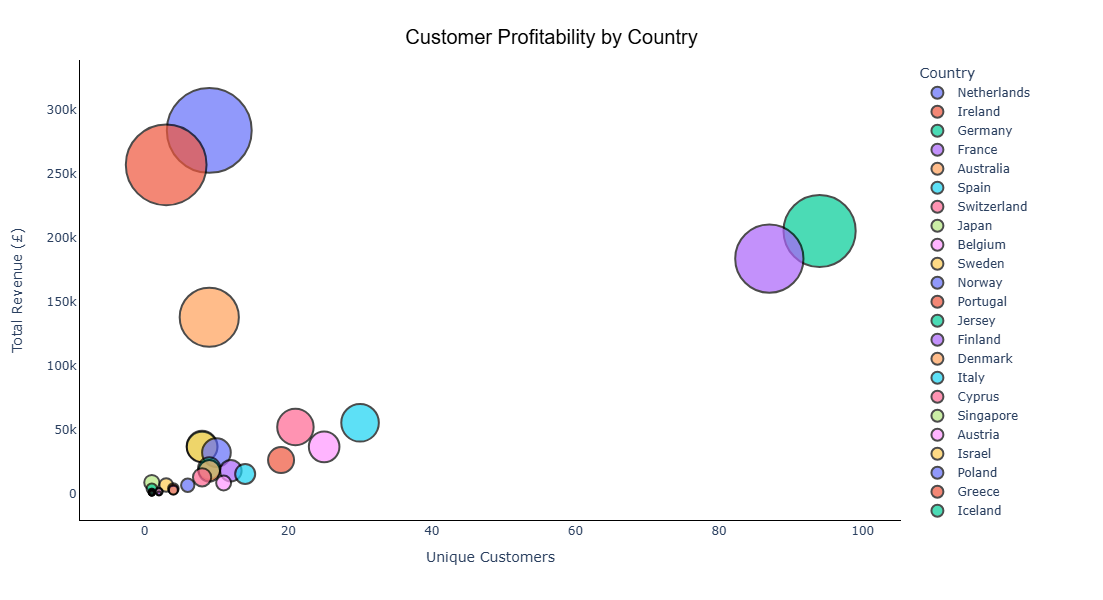

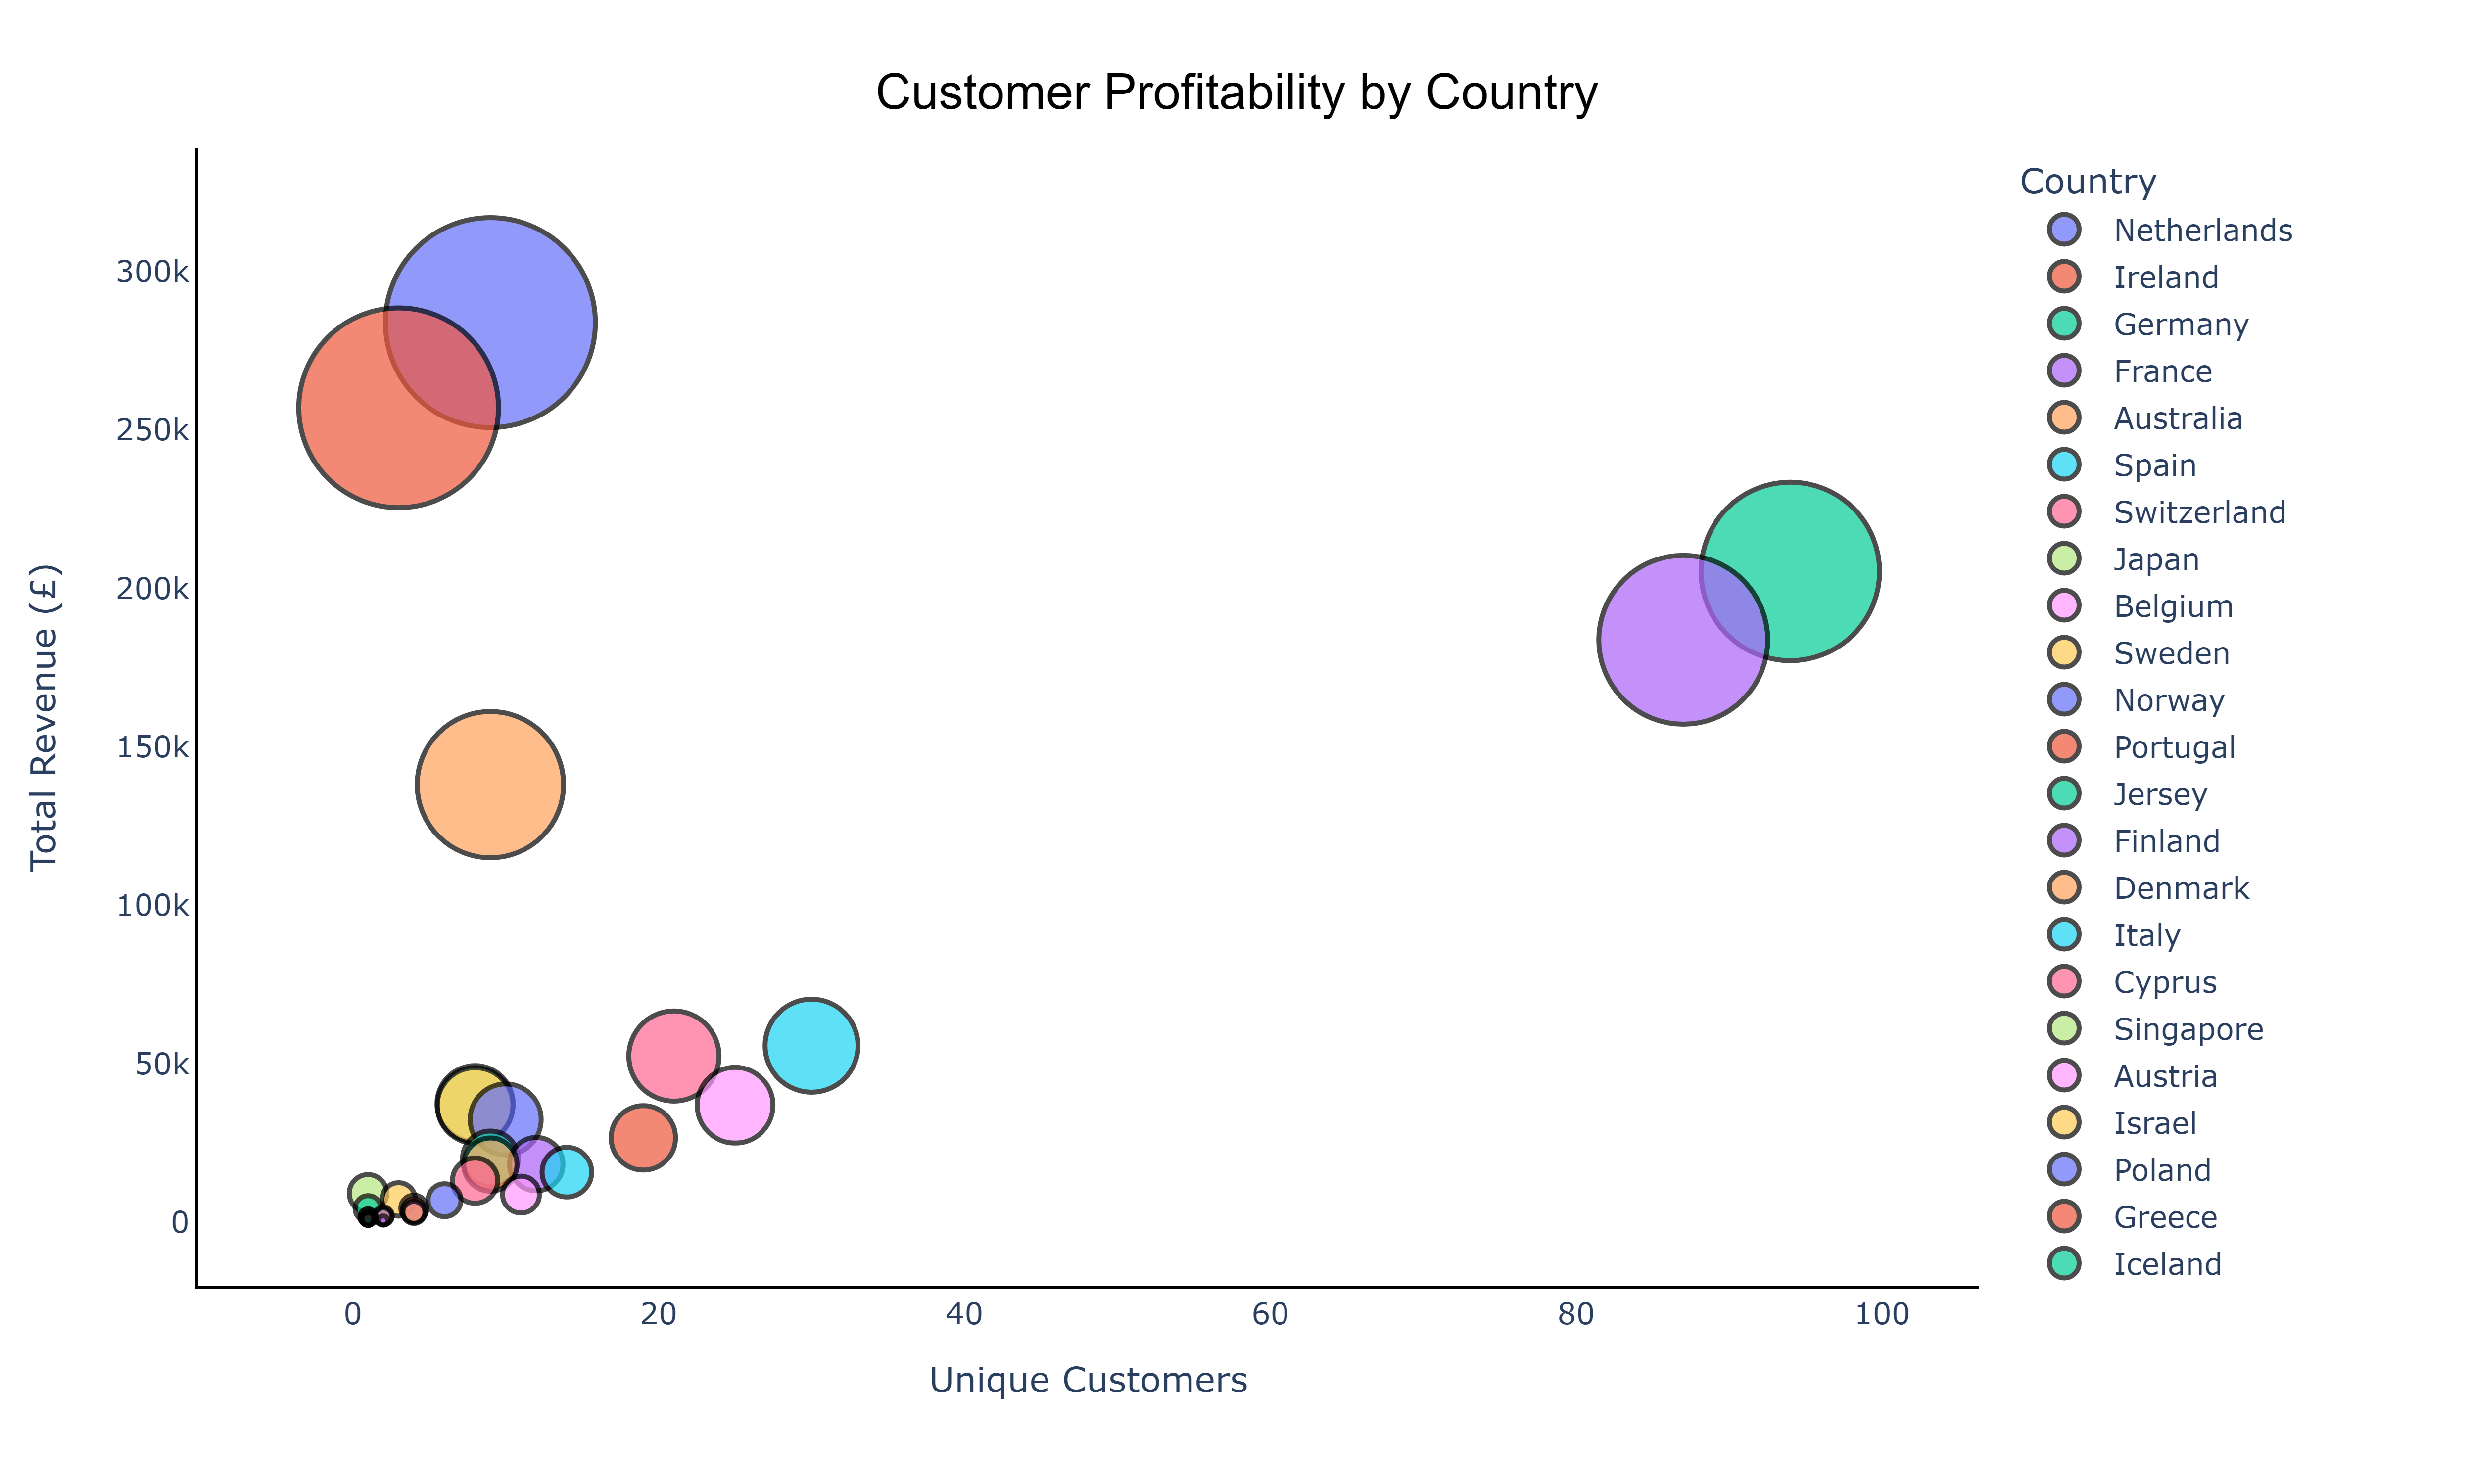

In [24]:
# Creating the scatter plot
fig = px.scatter(df_country_profitability, x='unique_customers', y='total_revenue', size='total_revenue', color='Country', 
                 hover_name='Country', size_max=60, custom_data=['revenue_per_customer'], 
                 labels={'unique_customers': 'Unique Customers', 'revenue_per_customer': 'Revenue per Customer (£)', 
                         'total_revenue': 'Total Revenue (£)'})
fig.update_traces(marker=dict( line=dict(width=2, color='black')),
    hovertemplate=("<b>%{hovertext}</b><br>" +   "Unique Customers: %{x:,}<br>" +  "Total Revenue: £%{y:,.2f}<br>" + 
                   "Revenue per Customer: £%{customdata[0]:,.2f}<extra></extra>"))

fig.update_layout(title={'text': 'Customer Profitability by Country', 'y': 0.95, 'x': 0.5, 'xanchor': 'center', 'yanchor': 'top', 
                         'font': dict(size=20, family='Arial', color='black')}, height=600, width=1000, plot_bgcolor='white', paper_bgcolor='white',
                  xaxis=dict(title='Unique Customers', showline=True, linecolor='black', showgrid=False),
                  yaxis=dict(title='Total Revenue (£)', showline=True, linecolor='black', showgrid=False))
fig.show()

# Save as standalone HTML
pyo.plot(fig, filename="global_scatter_plot.html", auto_open=False)

# Save static image of the figure
pio.write_image(fig, "global_scatter_plot.png", format="png", scale=5)
display(Image(filename="global_scatter_plot.png"))

> This scatter plot analyzes the relationship between unique customers and total revenue across countries (*excluding the United Kingdom*). Each bubble’s size represents total revenue, while hover details reveal revenue per customer—emphasizing markets where smaller customer bases generate disproportionately high revenue.  
> By comparing revenue against customer count, the visualization identifies **high-value international markets** that could benefit from targeted retention or expansion strategies, even with limited scale.   

### **6. Customer Retention & Churn**
*How well do we retain customers over time?*

#### **6.1 6-Month Retention Rate & Churn Rate**
- *What percentage of customers who purchased before June 2011 returned after?*
- *How many customers have churned?*

In [25]:
%%sql
WITH
customers_before_june AS (
    SELECT DISTINCT customer_id
    FROM online_retail
    WHERE invoice_date < '2011-06-01'
      AND customer_id IS NOT NULL
),
customers_after_june AS (
    SELECT DISTINCT customer_id
    FROM online_retail
    WHERE invoice_date >= '2011-06-01'
      AND customer_id IS NOT NULL
),
retained AS (                     -- Retained customers (present in both periods)
    SELECT customer_id
    FROM customers_before_june
    WHERE customer_id IN (SELECT customer_id FROM customers_after_june)
),
churned AS (                      -- Churned customers (only before June, not after)
    SELECT customer_id
    FROM customers_before_june
    WHERE customer_id NOT IN (SELECT customer_id FROM customers_after_june)
)
SELECT
    (SELECT COUNT(*) FROM retained) AS retained_customers,
    ROUND((SELECT COUNT(*) * 100.0 FROM retained) / (SELECT COUNT(*) FROM customers_before_june), 1) AS retention_rate,
    (SELECT COUNT(*) FROM churned) AS churned_customers,
    ROUND((SELECT COUNT(*) * 100.0 FROM churned) / (SELECT COUNT(*) FROM customers_before_june), 1) AS churn_rate;

Running query in 'sqlite:///online_retail.db'

retained_customers,retention_rate,churned_customers,churn_rate
1923,70.8,793,29.2


> Out of all customers who made purchases before **June 2011**, around **70.8% were retained**, while **29.2% churned**, meaning they did not return after that period. This relatively high retention rate suggests strong customer loyalty, but nearly a third of the customer base was lost, signaling an opportunity for improved engagement strategy.

#### **6.2 Monthly Retained vs Churned Customers**

In [26]:
query = """
WITH customer_months AS (
    SELECT DISTINCT
        customer_id,
        strftime('%Y-%m', invoice_date) AS month
    FROM online_retail
),
this_month_customers AS (
    SELECT
        customer_id,
        month AS this_month
    FROM customer_months
),
next_month_customers AS (
    SELECT
        customer_id,
        month AS next_month
    FROM customer_months
),
customer_retention AS (
    SELECT
        tmc.customer_id,
        tmc.this_month,
        CASE
            WHEN nmc.next_month IS NOT NULL THEN 'Retained Customer'
            ELSE 'Churned Customer'
        END AS customer_status
    FROM this_month_customers tmc
    LEFT JOIN next_month_customers nmc
        ON tmc.customer_id = nmc.customer_id
        AND nmc.next_month = strftime('%Y-%m', date(tmc.this_month || '-01', '+1 month'))
),
pivoted AS (
    SELECT
        this_month AS month,
        SUM(CASE WHEN customer_status = 'Retained Customer' THEN 1 ELSE 0 END) AS retained_customers,
        SUM(CASE WHEN customer_status = 'Churned Customer' THEN 1 ELSE 0 END) AS churned_customers
    FROM customer_retention
    WHERE this_month != IFNULL((SELECT MAX(month) FROM customer_months), '')
    GROUP BY this_month
)
SELECT 
    month,
    (retained_customers + churned_customers) AS total_customers,
    retained_customers,
    churned_customers
FROM pivoted
ORDER BY month;
"""

df_retention = pd.read_sql(query, conn)
df_retention

,month,total_customers,retained_customers,churned_customers
0,2010-12,884,323,561
1,2011-01,739,260,479
2,2011-02,757,290,467
3,2011-03,973,301,672
4,2011-04,853,366,487
5,2011-05,1054,410,644
6,2011-06,990,365,625
7,2011-07,946,386,560
8,2011-08,933,423,510
9,2011-09,1259,487,772


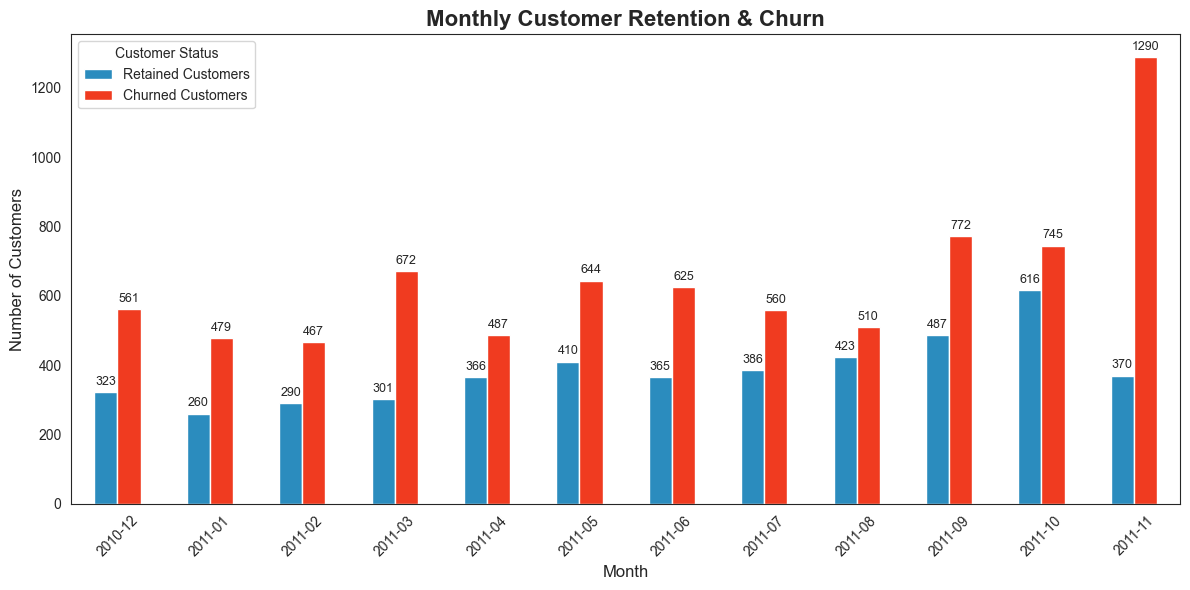

In [27]:
# Prepare the data
df_retention.rename(columns={'retained_customers': 'Retained Customers', 'churned_customers': 'Churned Customers'}, inplace=True)
df_plot = df_retention.set_index('month')[['Retained Customers', 'Churned Customers']]

# Plotting grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))
df_plot.plot(kind='bar', stacked=False, ax=ax, color=['#2b8cbe', '#f03b20'])
ax.set_title('Monthly Customer Retention & Churn', fontsize=16, fontweight='bold')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Number of Customers', fontsize=12)
plt.xticks(rotation=45)
ax.legend(title='Customer Status')
ax.grid(False)

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', fontsize=9, padding=3)

plt.tight_layout()
plt.show()

> The retention trend fluctuates month-to-month, with the **highest customer activity** in **October and November 2011**. However, **churn numbers also increase sharply** in these months, especially in **November**, where over **1,200 customers failed to return** the following month. This suggests a spike in one-time purchases, possibly driven by seasonal or promotional sales, highlighting the importance of post-purchase follow-up to retain these customers.

### **7. Customer Purchase Frequency Analysis**
*What percentage of customers made more than one purchase, and how many customers purchased only once and never returned?*

In [28]:
%%sql
WITH customer_orders AS (
    SELECT customer_id, COUNT(DISTINCT invoice_no) AS order_count
    FROM online_retail
    GROUP BY customer_id
),
unique_customers AS (
    SELECT COUNT(DISTINCT customer_id) AS total_customers
    FROM online_retail
),
repeat_customers AS (
    SELECT COUNT(*) AS repeat_customer_count
    FROM customer_orders
    WHERE order_count > 1
),
one_time_buyers AS (
    SELECT COUNT(*) AS one_time_buyers_count
    FROM customer_orders
    WHERE order_count = 1
)
SELECT
    total_customers,
    repeat_customer_count,
    ROUND((repeat_customer_count * 1.0 / total_customers) * 100, 1) AS repeat_customer_rate,
    one_time_buyers_count,
    ROUND((one_time_buyers_count * 1.0 / total_customers) * 100, 1) AS one_time_buyers_percent
FROM unique_customers
JOIN repeat_customers
JOIN one_time_buyers;

Running query in 'sqlite:///online_retail.db'

total_customers,repeat_customer_count,repeat_customer_rate,one_time_buyers_count,one_time_buyers_percent
4334,2829,65.3,1505,34.7


> Out of **4,334 total customers**, approximately **65.3%** made **more than one purchase**, classifying them as **repeat customers**. The remaining **34.7% (1,505 customers)** were **one-time buyers** who never returned after their initial purchase. While a strong majority demonstrates customer loyalty, the relatively high share of one-time buyers points to an opportunity for improving post-purchase engagement and implementing retention campaigns.

### **8. Customer Acquisition Trends**
*How many new vs existing customers are active each month?*

In [29]:
query = """
WITH first_purchase_month AS (
    SELECT 
        customer_id,
        MIN(strftime('%Y-%m', invoice_date)) AS first_purchase_month
    FROM online_retail
    GROUP BY customer_id
),
monthly_orders AS (
    SELECT
        customer_id,
        strftime('%Y-%m', invoice_date) AS order_month
    FROM online_retail
),

customer_classification AS (
    SELECT
        mo.order_month,
        CASE
            WHEN mo.order_month = fpm.first_purchase_month THEN 'New Customer'
            ELSE 'Existing Customer'
        END AS customer_type,
        mo.customer_id
    FROM monthly_orders mo
    JOIN first_purchase_month fpm ON mo.customer_id = fpm.customer_id
)
SELECT
    order_month,
    COUNT(DISTINCT CASE WHEN customer_type = 'New Customer' THEN customer_id END) AS new_customers,
    COUNT(DISTINCT CASE WHEN customer_type = 'Existing Customer' THEN customer_id END) AS existing_customers
FROM customer_classification
GROUP BY order_month
ORDER BY order_month;
"""

df_acquisition = pd.read_sql(query, conn)
df_acquisition

,order_month,new_customers,existing_customers
0,2010-12,884,0
1,2011-01,416,323
2,2011-02,380,377
3,2011-03,452,521
4,2011-04,300,553
5,2011-05,284,770
6,2011-06,242,748
7,2011-07,187,759
8,2011-08,169,764
9,2011-09,299,960


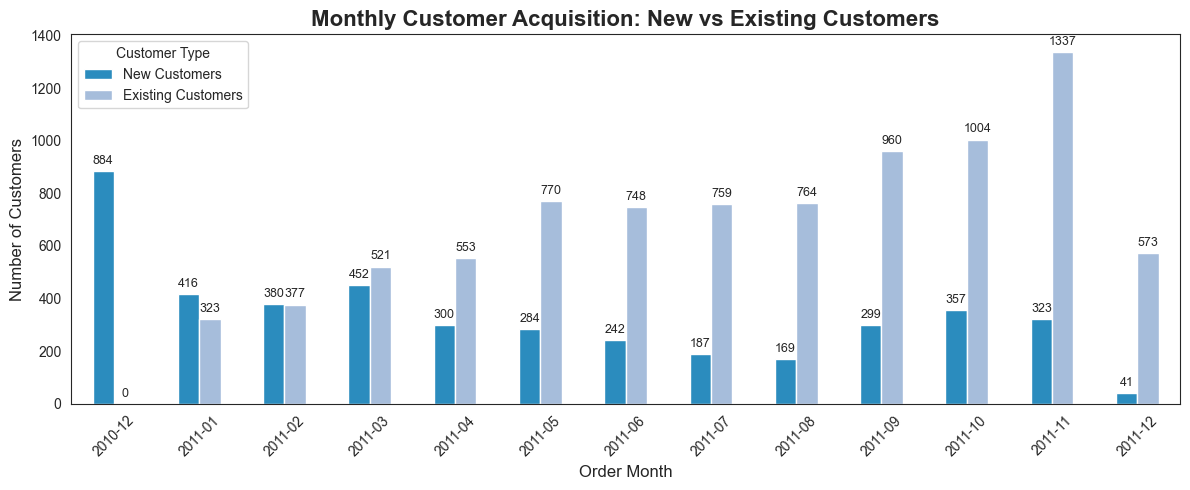

In [30]:
# Set index to order_month for plotting
df_plot = df_acquisition.set_index('order_month')
df_plot.columns = ['New Customers', 'Existing Customers']
conn.close()

# Plotting the figure
fig, ax = plt.subplots(figsize=(12, 5))
df_plot.plot(kind='bar', stacked=False, ax=ax, color=['#2b8cbe', '#a6bddb'])
ax.set_title('Monthly Customer Acquisition: New vs Existing Customers', fontsize=16, fontweight='bold')
ax.set_xlabel('Order Month', fontsize=12)
ax.set_ylabel('Number of Customers', fontsize=12)
plt.xticks(rotation=45)
ax.legend(title='Customer Type')
ax.grid(False)

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', fontsize=9, padding=3)

plt.tight_layout()
plt.show()

> The figure shows that December 2010 had only new customers (since it’s the first month in the dataset). From January 2011 onward, the proportion of existing customers steadily increases, indicating strong customer retention over time.  
Peak acquisition months include **March, September, and October 2011**, suggesting successful acquisition or seasonal campaigns. Notably, **November 2011** shows the **highest number of active existing customers**, reinforcing the impact of holiday-related promotions or edations.

### 1. Calculating RFM Scores

#### Calculating Recency (R)
We will identify each customer's most recent transaction and calculate the number of days since their last purchase. 

In [ ]:
%%sql
SELECT MAX(invoice_date) AS last_order_date
FROM online_retail;

> Using *'2011-12-09'* (the most recent date in the dataset) as the reference point, we will analyze transactions recorded between '2010-12-01' and '2011-12-09'.

In [ ]:
%%sql
SELECT customer_id,
       MAX(invoice_date) AS last_purchase_date,
       (julianday('2011-12-09') - julianday(MAX(invoice_date))) AS recency
FROM online_retail
GROUP BY customer_id
LIMIT 10;

#### Calculating Frequency (F)
Counting how many unique transactions each customer made.

In [ ]:
%%sql
SELECT customer_id,
       COUNT(DISTINCT invoice_no) AS frequency
FROM online_retail
GROUP BY customer_id
LIMIT 10;

#### Calculating Monetary (M)
Suming total spending per customer.

In [ ]:
%%sql
SELECT customer_id,
       ROUND(SUM(total_sales), 2) AS monetary
FROM online_retail
GROUP BY customer_id
LIMIT 10;

#### Calculating Average RFM Values

In [ ]:
%%sql
WITH rfm AS (
    SELECT 
       o.customer_id,
       (julianday('2011-12-09') - julianday(MAX(o.invoice_date))) AS recency,
       COUNT(DISTINCT o.invoice_no) AS frequency,
       ROUND(SUM(o.total_sales), 2) AS monetary
    FROM online_retail o
    GROUP BY o.customer_id
)
SELECT 
    ROUND(AVG(recency), 2) AS avg_recency,
    ROUND(AVG(frequency), 2) AS avg_frequency,
    ROUND(AVG(monetary), 2) AS avg_monetary
FROM rfm;

> The average values across all customers are:
> - **Recency**: 92.23 days → On average, customers haven't purchased in over 3 months.
> - **Frequency**: 4.25 orders → Most customers have made around 4 purchases in the observed period.
> - **Monetary**: £2,015.97 → On average, each customer has spent over £2,000, indicating a relatively high customer value.

#### Assigning RFM Scores 
Each RFM metric (Recency, Frequency, Monetary) is scored on a scale of 1 to 5 based on its performance and value, with higher scores indicating better customer engagement and spending behavior.

In [ ]:
%%sql
CREATE VIEW rfm_analysis AS
WITH rfm AS (
    SELECT 
       o.customer_id,
       (julianday('2011-12-09') - julianday(MAX(o.invoice_date))) AS recency,
       COUNT(DISTINCT o.invoice_no) AS frequency,
       ROUND(SUM(o.total_sales), 2) AS monetary
    FROM online_retail o
    GROUP BY o.customer_id
)
SELECT 
    customer_id,
    recency,
    frequency,
    monetary,
    -- R-Score => Lower recency = better => ORDER BY recency DESC
    NTILE(5) OVER (ORDER BY recency DESC) AS r_score,
    -- F-Score => Higher frequency = better => ORDER BY frequency ASC
    NTILE(5) OVER (ORDER BY frequency) AS f_score,
    -- M-Score => Higher spending = better => ORDER BY monetary ASC
    NTILE(5) OVER (ORDER BY monetary) AS m_score
FROM rfm;

In [ ]:
%%sql
SELECT * FROM rfm_analysis
LIMIT 10;

### Distribution of Recency, Frequency, and Monetary Metrics Across Customers

In [ ]:
query = """
SELECT customer_id, recency, frequency, monetary
FROM rfm_analysis;
"""
df_rfm = pd.read_sql(query, conn)

# Plotting the histograms
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(df_rfm['recency'], bins=30, kde=True, ax=axes[0], color="blue")
axes[0].set_title("Recency Distribution")
axes[0].set_xlabel("Days Since Last Purchase")

sns.histplot(df_rfm['frequency'], bins=30, kde=True, ax=axes[1], color="orange")
axes[1].set_title("Frequency Distribution")
axes[1].set_xlabel("Number of Purchases")

sns.histplot(df_rfm['monetary'], bins=30, kde=True, ax=axes[2], color="green")
axes[2].set_title("Monetary Distribution")
axes[2].set_xlabel("Total Spend (£)")

plt.tight_layout()
plt.show()

> The histograms display how customers are distributed across recency (days since last purchase), frequency (number of purchases), and monetary value (total spend in £). The histograms show:
> - **Recency** is **heavily right-skewed**, with most customers not purchasing recently, suggesting potential inactivity or churn.
> - **Frequency** shows that a majority of customers placed **fewer than 5 orders**, with a steep drop-off beyond that.
> - **Monetary** has a **long-tailed distribution**, where most customers spend under £5,000, but a small elite group contributes significantly more, with some spending over £10,000.

> These plots confirm a **Pareto pattern** — a small portion of customers drives the bulk of business value, highlighting the need for targeted retention and loyalty strategies.

### 2. Assigning Customer Segments

This table categorizes customers based on their recency (R), frequency (F), and monetary (M) scores, providing insights into their engagement levels and suggesting appropriate marketing actions.

---
| S. No | **Customer Segment**       | Description                                                                 | Marketing Action & Recommendations | **R Score** | **(F+M)/2 Score** |  
|------|----------------------------|---------------------------------------------------------------------------|----------------------------------|------------|-----------------|  
| 1    | <span style="color:#339AF0;">**Champions**</span>             | Most loyal and valuable customers who frequently purchase and engage with your brand. | Introduce new and upcoming products and drops. Reward them and help them share updates. Provide priority access and loyalty perks. | 5          | 4 - 5        |  
| 2    | <span style="color:#DA77F2;">**Potential Loyalists**</span>   | Customers with growing interest and engagement, indicating potential loyalty. | Offer membership/loyalty programs, recommend other products, nurture with personalized offers and incentives. | 4 - 5      | 2 - 3        |  
| 3    | <span style="color:#91A7FF;">**Loyal Customers**</span>       | Regular customers who consistently engage with and purchase from your brand. | Upsell higher-value products, ask for reviews, maintain engagement with personalized communication and loyalty programs. | 3 - 4      | 4 - 5        |  
| 4    | <span style="color:#0CA678;">**New Customers**</span>      | First-time buyers who recently started engaging with your brand. | Provide onboarding support, give them early success, start building a relationship with welcome emails and special offers. | 5          | 1            |  
| 5    | <span style="color:#38D9A9;">**Promising**</span>             | New or occasional customers with good potential based on recent behavior. | Encourage further engagement with special offers, tailored content, or invitations to loyalty programs. Check on their need for replenishment. | 4          | 1            |  
| 6    | <span style="color:#FFA8A8;">**Needs Attention**</span>       | Customers with decent engagement but show early signs of decreasing interest or activity. | Make limited-time offers, recommend products based on past purchases, re-engage with personalized outreach. | 3          | 3            |  
| 7    | <span style="color:#FAB005;">**About to Sleep**</span>        | Customers who have purchased before but have shown declining engagement or inactivity. | Send personalized re-engagement campaigns, offer discounts or reminders about their previous activity. Introduce them to new products. | 3          | 1 - 2        |  
| 8    | <span style="color:#E03131;">**Can't Lose Them**</span>       | High-value customers with recent inactivity or signs of disengagement. | Provide VIP treatment, personalized outreach, exclusive offers, and reconnect with high-value incentives. | 1 - 2      | 5            |  
| 9    | <span style="color:#F76707;">**At Risk**</span>               | Customers with reduced frequency of purchase or engagement, indicating potential churn. | Send personalized emails to reconnect, offer renewals, provide helpful resources, and recommend popular products. | 1 - 2      | 3 - 4        |  
| 10   | <span style="color:#757575;">**Hibernating**</span>           | Customers who were once active but have not engaged in a significant period. | Offer other relevant products and special discounts. Recreate brand value and reactivate through targeted campaigns. | 1 - 2      | 1 - 2        |

---

In [ ]:
%%sql
CREATE VIEW customer_segments AS
SELECT customer_id,
       ROUND((r_score + f_score + m_score) / 3.0, 1) AS avg_rfm,
       (r_score * 100 + f_score * 10 + m_score) AS rfm_score,
       CASE
           WHEN r_score = 5 AND (f_score + m_score) / 2 BETWEEN 4 AND 5 THEN 'Champions'
           WHEN r_score BETWEEN 3 AND 4 AND (f_score + m_score) / 2 BETWEEN 4 AND 5 THEN 'Loyal Customers'
           WHEN r_score BETWEEN 4 AND 5 AND (f_score + m_score) / 2 BETWEEN 2 AND 3 THEN 'Potential Loyalists'
           WHEN r_score = 5 AND (f_score + m_score) / 2 = 1 THEN 'New Customers'
           WHEN r_score = 4 AND (f_score + m_score) / 2 = 1 THEN 'Promising'
           WHEN r_score = 3 AND (f_score + m_score) / 2 = 3 THEN 'Needs Attention'
           WHEN r_score = 3 AND (f_score + m_score) / 2 BETWEEN 1 AND 2 THEN 'About to Sleep'
           WHEN r_score BETWEEN 1 AND 2 AND (f_score + m_score) / 2 = 5 THEN 'Can’t Lose Them'
           WHEN r_score BETWEEN 1 AND 2 AND (f_score + m_score) / 2 BETWEEN 3 AND 4 THEN 'At Risk'
           WHEN r_score BETWEEN 1 AND 2 AND (f_score + m_score) / 2 BETWEEN 1 AND 2 THEN 'Hibernating'
           ELSE 'Others'
       END AS customer_segment
FROM (
    SELECT
        customer_id, r_score, f_score, m_score
    FROM rfm_analysis
) AS sub;

In [ ]:
%%sql
SELECT * FROM customer_segments   
LIMIT 10;

### Customer Segments vs. RFM Score Distribution

In [ ]:
query = "SELECT customer_segment, rfm_score FROM customer_segments;"
df_rfm = pd.read_sql(query, conn)

# Assigning colors to customer segments
segment_colors = {
    "Champions": "#A5D8FF",
    "Loyal Customers": "#CFE2FF",
    "Potential Loyalists": "#D1B3FF",  
    "Needs Attention": "#FFCAB1",
    "About to Sleep": "#FFD699",
    "Promising": "#A8E6CF",  
    "New Customers": "#12ca93",
    "At Risk": "#FF9F80",
    "Can’t Lose Them": "#FF7F7F",
    "Hibernating": "#E8E8E8"}
unique_segments = df_rfm['customer_segment'].unique()
segment_palette = {seg: segment_colors.get(seg, '#D3D3D3') for seg in unique_segments}

#Plotting the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x="customer_segment", y="rfm_score", hue="customer_segment", data=df_rfm, palette=segment_palette, legend=False)
plt.xticks(rotation=45)
plt.xlabel("Customer Segment", fontsize=12)
plt.ylabel("RFM Score", fontsize=12)
plt.title("RFM Score Distribution Across Customer Segments", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

> *This boxplot shows the spread of RFM scores across each customer segment, highlighting median behavior and variability within segments. Segments with higher median scores are typically more valuable or engaged customers.*

### Customer Segment Analysis  
Detailed analysis of customer segments by calculating key metrics for each segment.

In [ ]:
%%sql
SELECT 
    seg.customer_segment, 
    COUNT(rfm.customer_id) AS total_customers,
    ROUND(SUM(rfm.monetary), 2) AS total_revenue,
    ROUND(SUM(rfm.monetary) / SUM(rfm.frequency), 2) AS avg_order_value, 
    ROUND(AVG(rfm.recency), 2) AS avg_recency,   
    ROUND(AVG(rfm.frequency), 2) AS avg_frequency, 
    ROUND(AVG(rfm.monetary), 2) AS avg_monetary 
FROM customer_segments seg
JOIN rfm_analysis rfm ON seg.customer_id = rfm.customer_id
GROUP BY seg.customer_segment
ORDER BY total_revenue DESC;

- **Champions** (589 customers) generate over **£4.46M**, nearly half of all revenue, with an AOV of £585 and ~13 orders each.
- **Loyal Customers** (723 customers) contribute **£2.29M**, showing strong recurring behavior and healthy AOV.
- **At Risk** and **Can’t Lose Them** customers, while fewer, still generate high value, highlighting them as recovery priorities.
- **Hibernating** and **About to Sleep** are larger in size but contribute significantly less, indicating disengagement.
- **New Customers** and **Promising** are small and low-value, but represent opportunity if nurtured early.

### Comparative Heatmaps of Customer Segments by RFM Metrics

In [ ]:
# Fetch RFM averages by segment
query = """
    SELECT seg.customer_segment, 
           AVG(rfm.recency) AS avg_recency, 
           AVG(rfm.frequency) AS avg_frequency, 
           AVG(rfm.monetary) AS avg_monetary
    FROM rfm_analysis rfm
    JOIN customer_segments seg ON rfm.customer_id = seg.customer_id
    GROUP BY seg.customer_segment;
"""
df_rfm_heatmap = pd.read_sql(query, conn)
df_rfm_heatmap.set_index("customer_segment", inplace=True)   # Set 'customer_segment' as index for heatmap

# Define individual color maps
colormaps = {
    "avg_recency": "Blues_r",  # Lower Recency is better
    "avg_frequency": "Oranges",  # Higher Frequency is better
    "avg_monetary": "Greens"   # Higher Monetary is better
}

# Creating 3 heatmaps side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, (column, cmap) in enumerate(colormaps.items()):
    sns.heatmap(df_rfm_heatmap[[column]], annot=True, fmt=".1f", cmap=cmap, linewidths=0.5, ax=axes[i], annot_kws={"size": 12})
    axes[i].set_title(column.replace("avg_", "").capitalize(), fontsize=14, fontweight="bold")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Customer Segment" if i == 0 else "")
plt.tight_layout()
plt.show()

These side-by-side heatmaps compare average **Recency**, **Frequency**, and **Monetary** across customer segments:
- **Champions** have the best scores across all three dimensions (lowest recency, highest frequency and monetary).
- **Hibernating** and **At Risk** segments stand out with high recency (inactive), but differ in value and frequency.
- **Can’t Lose Them** also show low recency with high monetary value — a clear recovery opportunity.
- The visual layout clearly communicates where engagement and spending are strongest or slipping.

### Customer Distribution by Recency and Frequency + Monetary Scores

In [ ]:
# Fetch R & F Scores with Customer Count
query = """
    SELECT r_score, (f_score + m_score) / 2 AS avg_fm_score, COUNT(customer_id) AS total_customers
    FROM rfm_analysis
    GROUP BY r_score, avg_fm_score;
"""
df_grid = pd.read_sql(query, conn)

# Pivot the table for heatmap format
heatmap_data = df_grid.pivot(index="avg_fm_score", columns="r_score", values="total_customers")

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="coolwarm", linewidths=0.5, cbar=True)
plt.xlabel("Recency Score")
plt.ylabel("(Frequency + Monetary) / 2 Score")
plt.title("Customers by RFM Scores")
plt.xticks(rotation=0)  # Ensure the labels are readable
plt.yticks(rotation=0)
plt.show()

This heatmap shows the **concentration of customers** across a matrix of **Recency** and **(Frequency + Monetary)/2** scores:
- The densest cluster lies in mid-to-low R scores (i.e., older last purchases), with moderate FM scores — indicating many customers are at risk or dormant.
- Few customers have low recency and high FM scores — aligning with the “Champion” profile. This grid helps visually assess which scoring combinations contain the largest customer bases and where to target marketing efforts.

### RFM Segmentation Map: Customer Segments by Recency and Frequency/Monetary

In [ ]:
# Fetch RFM segment data
query = """
    SELECT cs.customer_segment, 
           ra.r_score, 
           (ra.f_score + ra.m_score) / 2 AS avg_fm_score, 
           COUNT(cs.customer_id) AS customer_count
    FROM customer_segments cs
    JOIN rfm_analysis ra ON cs.customer_id = ra.customer_id
    GROUP BY cs.customer_segment, ra.r_score, avg_fm_score
    ORDER BY avg_fm_score DESC, ra.r_score;
"""
df_mosaic = pd.read_sql(query, conn)

In [ ]:
# Calculate total customers
total_customers = df_mosaic['customer_count'].sum()

# Group by segment, recency, and average frequency+monetary score
pivot_data = df_mosaic.groupby(["customer_segment", "r_score", "avg_fm_score"])["customer_count"].sum().reset_index()

# Plot figure
fig, ax = plt.subplots(figsize=(16.5, 9), facecolor="white")
ax.set_aspect(0.5)
for spine in ax.spines.values():
    spine.set_visible(False)

# Prepare merged blocks for each segment
merged_blocks = []
for segment in pivot_data["customer_segment"].unique():
    segment_data = pivot_data[pivot_data["customer_segment"] == segment]

    min_r = segment_data["r_score"].min()
    max_r = segment_data["r_score"].max()
    min_fm = segment_data["avg_fm_score"].min()
    max_fm = segment_data["avg_fm_score"].max()

    total_segment_customers = segment_data["customer_count"].sum()
    percentage = round((total_segment_customers / total_customers) * 100, 2)

    merged_blocks.append({
        "segment": segment,
        "r_start": min_r - 1,
        "r_width": max_r - min_r + 1,
        "fm_start": min_fm - 1,
        "fm_height": max_fm - min_fm + 1,
        "customer_count": total_segment_customers,
        "percentage": percentage
    })

# Draw the merged rectangles and label them
for block in merged_blocks:
    rect = Rectangle((block["r_start"], block["fm_start"]), block["r_width"], block["fm_height"], 
                     facecolor=segment_colors.get(block["segment"], "#D3D3D3"), edgecolor="white", linewidth=2)
    ax.add_patch(rect)
    ax.text(block["r_start"] + block["r_width"] / 2, block["fm_start"] + block["fm_height"] / 2,
            f"{block['segment']}\n{block['customer_count']:,}\n({block['percentage']}%)",
            ha="center", va="center", fontsize=9.5, fontweight="bold", color="black")
tick_positions = np.arange(5) + 0.5
ax.set_xticks(tick_positions)
ax.set_xticklabels(range(1, 6), fontsize=12, color="black", fontweight="bold")
ax.set_yticks(tick_positions)
ax.set_yticklabels(range(1, 6), fontsize=12, color="black", fontweight="bold")
ax.tick_params(axis='both', which='both', length=0, pad=-2)
label_fontsize = 14
ax.set_xlabel("Recency", fontsize=label_fontsize, fontweight="bold", color="black", labelpad=5)  
ax.set_ylabel("(Frequency + Monetary) / 2", fontsize=label_fontsize, fontweight="bold", color="black", labelpad=10)  
plt.title("Customer Segments", fontsize=16, fontweight="bold", color="black", pad=10)
plt.grid(False)
plt.axis("scaled")
plt.show()

> This shows how customers are distributed based on their RFM scores. Each rectangle corresponds to a customer segment (e.g., Champions, Potential Loyalists). Labels inside each rectangle show segment name, count, and percentage of total customer. 
> - **Champions** and **Loyal Customers** dominate the top-right of the grid — high FM scores and low recency, signaling active, high-value buyers.
> - Segments like **At Risk** and **Hibernating** fall toward lower FM and higher recency, indicating disengagement and potential churn.
> - Mid-tier segments like **Promising** and **Needs Attention** occupy narrow score bands, suggesting more targeted growth or retention potential.

### Revenue Analysis by Customer Segment
Revenue Distribution and Trends by Customer Segment

In [ ]:
# Revenue over time by segment 
query_revenue_overtime = """
    SELECT 
        strftime('%Y-%m', o.invoice_date) AS month,
        seg.customer_segment,
        ROUND(SUM(o.total_sales), 2) AS total_revenue
    FROM customer_segments seg
    JOIN online_retail o ON seg.customer_id = o.customer_id
    GROUP BY month, seg.customer_segment
    ORDER BY month ASC, total_revenue DESC;
"""
df_revenue_overtime = pd.read_sql(query_revenue_overtime, conn)
df_revenue_overtime

In [ ]:
# Revenue contribution by segment 
query_revenue_cont = """
    SELECT seg.customer_segment,
           ROUND(SUM(o.total_sales), 2) AS total_revenue
    FROM customer_segments seg
    JOIN online_retail o ON seg.customer_id = o.customer_id
    GROUP BY seg.customer_segment
    ORDER BY total_revenue DESC;
"""
df_revenue_cont = pd.read_sql(query_revenue_cont, conn)
df_revenue_cont

In [ ]:
# Consistent color palette for both charts
segment_palette_line = [segment_colors.get(seg, "#D3D3D3") for seg in df_revenue_cont["customer_segment"]]
color_dict = {seg: segment_colors.get(seg, "#D3D3D3") for seg in df_revenue_cont["customer_segment"]}

# Create subplots: 1 row, 2 columns
fig = make_subplots(rows=1, cols=2, subplot_titles=("Total Revenue by Customer Segment Over Time", "Revenue Contribution by Customer Segment"),
                    specs=[[{"type": "scatter"}, {"type": "domain"}]])

# Line Chart 
for segment in df_revenue_overtime['customer_segment'].unique():
    data = df_revenue_overtime[df_revenue_overtime['customer_segment'] == segment]
    fig.add_trace(
     go.Scatter(x=data['month'], y=data['total_revenue'], mode='lines+markers', name=segment, line=dict(color=segment_colors.get(segment, "#D3D3D3")),
            hovertemplate=f"<b>{segment}</b><br>Month: %{{x}}<br>Revenue: £%{{y:,.2f}}<extra></extra>", showlegend=False), row=1, col=1)

# Pie Chart 
fig.add_trace(
    go.Pie(labels=df_revenue_cont['customer_segment'], values=df_revenue_cont['total_revenue'],
           marker=dict(colors=[segment_colors.get(seg, "#D3D3D3") for seg in df_revenue_cont['customer_segment']], line=dict(color='white', width=1)),
           textinfo='label+percent', hovertemplate="<b>%{label}</b><br>Revenue: £%{value:,.2f}<br>Percent: %{percent}<extra></extra>",
           showlegend=False), row=1, col=2)

# Final layout
fig.update_layout(height=600, width=1200, margin=dict(t=60, b=40, l=40, r=40), plot_bgcolor='white', paper_bgcolor='white', 
                  xaxis=dict(title="Month", showgrid=False, showline=True, linecolor='black', tickangle=-45, 
                             tickfont=dict(color='black'), titlefont=dict(color='black')),
                  yaxis=dict(title="Total Revenue (£)", showgrid=False, showline=True, linecolor='black', 
                             tickfont=dict(color='black'), titlefont=dict(color='black')), font=dict(color='black'))
fig.show()

# Save as standalone HTML
pyo.plot(fig, filename="revenue_by_segments.html", auto_open=False)

# Save static image of the figure
pio.write_image(fig, "revenue_by_segments.png", format="png", scale=5)
display(Image(filename="revenue_by_segments.png"))

> This dual visualization combines **temporal trends and segment-level revenue distribution** uncovering not only who drives the most revenue but **when**:  
> - The **line chart** shows monthly revenue trends by segment. **Champions and Loyal Customers** dominate revenue generation, with clear spikes during peak shopping seasons (e.g., October–November holiday period)
> - The **pie chart** shows overall revenue contribution share by segment. **Champions alone contribute over 50% of total revenue**, followed by Loyal Customers and At Risk segments — collectively making up the bulk of financial performance.<br><br/>

### Customer Segments Distribution by Recency and Frequency Scores

In [ ]:
# Fetch customer segmentation data with sales & order frequency
query = """
    SELECT 
    c.customer_segment, 
    AVG(r.recency) AS avg_recency,
    AVG(r.frequency) AS avg_frequency,
    AVG(r.monetary) AS avg_monetary,
    COUNT(c.customer_id) AS total_customers
FROM customer_segments c
JOIN rfm_analysis r ON c.customer_id = r.customer_id
GROUP BY c.customer_segment;
"""
df_order_segment = pd.read_sql(query, conn)

In [ ]:
# Close the database connection
conn.close()

# Create figure
fig = go.Figure()

# Add scatter (bubble plot)
fig.add_trace(
    go.Scatter(x=df_order_segment["avg_recency"], y=df_order_segment["avg_frequency"], mode='markers+text', text=df_order_segment["customer_segment"], 
               textposition='top center', textfont=dict(family='Verdana Bold',   size=14, color='black'),
               marker=dict(size=df_order_segment["total_customers"], sizemode='area', sizeref=2.*max(df_order_segment["total_customers"])/(80**2),
                           sizemin=10, color=df_order_segment["avg_monetary"], colorscale='tealrose', colorbar=dict(title='Avg Monetary (£)'),
                           line=dict(width=1.5, color='black')),
               hovertemplate= "<b>%{text}</b><br><br>" + "Recency: %{x:.2f} days<br>" + "Frequency: %{y:.2f} orders<br>" +      
                              "Average Monetary: £%{marker.color:,.2f}<br>" + "Total Customers: %{marker.size:,}<extra></extra>",
              showlegend=False))
fig.update_layout(
    title={'text': 'Customer Segments: Recency vs Frequency', 'y': 0.95, 'x': 0.5, 'xanchor': 'center', 'yanchor': 'top',
           'font': dict(size=20, family='Arial', color='black')},
    annotations=[
        dict(text="Note: Bubble Size = Customer Count and Color = Average Monetary Value (£).", x=0.3, y=-0.15, xref='paper', yref='paper',
             showarrow=False, font=dict(size=12, color="black"), xanchor='center')],
    height=700, width=1000, margin=dict(b=100), plot_bgcolor='white', paper_bgcolor='white',
    xaxis=dict(title="Average Recency (Days)", showgrid=False, linecolor='black'),
    yaxis=dict(title="Average Frequency (Orders)", showgrid=False, linecolor='black'))
fig.show()

# Save as standalone HTML
pyo.plot(fig, filename="segment_bubble_chart.html", auto_open=False)
# Save static image of the figure
pio.write_image(fig, "segment_bubble_chart.png", format="png", width=1000, height=600, scale=5)
display(Image(filename="segment_bubble_chart.png"))

This bubble chart plots customer segments by their average **Recency (x-axis)** and **Frequency (y-axis)**:
- **Bubble size** represents the number of customers in each segment.
- **Bubble color** reflects the segment’s **average monetary value (£)**.

Key insights:
- **Champions** have low recency, high frequency, and top monetary value — placed in the ideal top-left of the chart.
- Segments like **Can’t Lose Them** and **At Risk** also show strong past activity but suffer from high recency, placing them in the recovery zone.
- **Hibernating** and **Promising** segments cluster in low-frequency and low-value regions — good targets for reactivation or onboarding strategies.

<a id="section3"></a>
## <span style="color: #0D47A1;">**Insights & Recommendations**</span>

---



### **Customer Behaviour Insights (From EDA)**

#### **1. Revenue & Sales Patterns**
- **Insight:**  
  - Revenue peaked in **November 2011** (*likely due to holiday shopping*), with notable increases in **March**, **May**, and **September**.  
  - Most transactions occur **midday (10 AM–3 PM)** and **midweek (Tue–Thu)**, accounting for ~80% of total transactions and revenue.  
  - The average order value (AOV) is **£474.80**, with most purchases occurring during business hours — suggesting a predominantly **B2B customer base**.

- **Recommendations:**  
  - Schedule **flash sales**, **discounts**, and **“Midday Deals”** during peak weekday hours, particularly on **Thursdays**.  
  - Launch **seasonal campaigns in Q4** — especially October to November — and offer **loyalty incentives** to retain new seasonal shoppers.  
  - Experiment with **early morning (before 10 AM)** and **weekend promotions** to engage additional customer segments.

#### **2. Market Expansion Strategy**
- **Insight:**  
  - The **UK** drives **90% of orders** and **82% of revenue**, representing the **core market**.  
  - Secondary European markets (e.g., **Netherlands**, **Ireland**, **Germany**, **France**, **Australia**) exhibit **high revenue per customer**, suggesting bulk or high-value buying.  
  - Smaller countries with <1% revenue (e.g., **Sweden**, **Switzerland**, **Japan**) show potential based on **high AOVs**.

- **Recommendations:**  
  - Continue optimizing for the **UK**, while enhancing **personalized experiences** in high-value international markets.  
  - Test **localized campaigns** and **regional offers** in emerging markets to unlock untapped growth.

#### **3. Product & Sales Performance**
- **Insight:**  
  - Top-selling products are **home décor** and **seasonal gift items** (e.g., bird crafts, cake stands, heart-shaped holders), reflecting demand for **affordable, decorative, and giftable goods**.  
  - Product preferences vary by country — e.g., *art kits in Australia*, *chalk/gift packs in Austria*, *lip glosses in Bahrain*.

- **Recommendations:**  
  - Maintain strong inventory levels of **high-demand items**, especially ahead of **key holidays**.  
  - Expand **themed product bundles** and introduce a **“Top Picks by Country”** feature for regional targeting.

#### **4. Customer Loyalty & Retention**
- **Insight:**  
  - A **70.8% retention rate over 6 months** and **65.3% repeat buyer rate** show strong loyalty — but **34.7% of customers** purchase only once.  
  - Spikes in churn (e.g., **November 2011**) coincide with seasonal acquisition, indicating **short-term buyers** often fail to convert into loyal customers.

- **Recommendations:**  
  - Set up **post-holiday re-engagement flows** to convert seasonal shoppers into repeat buyers.  
  - Use **targeted onboarding** and **tailored offers** for first-time customers.  
  - Launch a **loyalty or rewards program** to incled in HTML for a presentation or markdown file!